<a href="https://colab.research.google.com/github/ericr6/platform_analysis/blob/main/deal_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task analysis of iExec MArketplace
This notebook create dataframe using the graph,then from the dataframe you can easily create dashboard or explore data.

Section 0 : import and define functions

Section 1 : retrieve latest data, latest N days with parameter N

Section 2 : Monitor hello world

Section 3 : Platform Availability indicator

Section 4 : Visualize recent activity

Section 5 : Save historical data in google drive [DO NOT USE]

Section 6 : Load full historical data from google drive

Section 7 : Visualisation from historical data

## Section 0 : import and define functions


In [3]:
# @title import stuffs
import requests
import json
import csv
from datetime import datetime, timedelta
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tabulate import tabulate

try:
    # Python 3.11+
    from datetime import UTC
except ImportError:
    # fallback pour versions plus anciennes
    from datetime import timezone
    UTC = timezone.utc


In [4]:
# @title Configuration

url_query_bellecour = 'https://thegraph.bellecour.iex.ec/subgraphs/name/bellecour/poco-v5'
url_query_arbitrum = 'https://thegraph.arbitrum.iex.ec/api/subgraphs/id/B1comLe9SANBLrjdnoNTJSubbeC7cY7EoNu6zD82HeKy'

workerpool_prod = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
workerpool_debug = '0xdb214a4a444d176e22030be1ed89da1b029320f2'
v8_learn_prod = '0x0975bfce90f4748dab6d6729c96b33a2cd5491f5'
v8_learn_debug = '0xf900995aa41ab29bc16ba0785d7c67ad9d301296'
wp_tdx = "0x4568effcec8ba0787e52deef10ed03267e7c95b1"

workerpool_prod_arb="0x2c06263943180cc024daffeee15612db6e5fd248"
workerpool_debug_arb="0xaaa90d37034fd1ea27d5ef2879f217fb6fd7f7ca"


In [5]:
# @title Load many Visualization functions

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import random

# Assuming your DataFrame is named 'df'
# Convert DATE column to datetime if it's not already
# Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in

def taskperday(df,workerpool_id, wpname):

    # Filter the DataFrame further for the specific worker pool
    df_taskday = df[df['WORKERPOOL ID'] == workerpool_id]
    len(df_taskday)

    df_taskday['DATE'] = pd.to_datetime(df_taskday['DATE'])
    # Define the date interval
    start_date = df_taskday['DATE'].min().strftime("%Y-%m-%d")
    end_date = df_taskday['DATE'].max().strftime("%Y-%m-%d")

    # Extract month from the DATE column
    df_taskday['Day'] = df_taskday['DATE'].dt.to_period('d')

    # Group by Month and STATUS, count occurrences
    status_counts = df_taskday.groupby(['Day', 'STATUS']).size().unstack(fill_value=0)

    # Plot
    status_counts.plot(kind='bar', stacked=True, figsize=(20, 8))

    plt.title('Tasks per day \n (Workerpool: {}) \n {} Start Date: {} | End Date: {}'.format(workerpool_id, wpname, start_date, end_date))
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Status')

    #Upscale resolution
    plt.figure(dpi=300)
    plt.show()

def taskplot(df,workerpool_filter, duration, wp_name):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]

    # Group by app name and date to count the number of uses of each dApp on each date
    app_usage = filtered_df.groupby(['APP NAME', pd.Grouper(key='DATE', freq='D')]).size().unstack(fill_value=0)

    # Get unique app names for y-axis ticks
    dapp_names = app_usage.index

    # Calculate figsize based on the number of dApps
    fig_height = max(1, len(dapp_names) * 0.5)  # Minimum height of 6 inches
    plt.figure(figsize=(25, fig_height))

    # Plot usage events for each dApp
    for i, app in enumerate(dapp_names):
        usage_dates = filtered_df[filtered_df['APP NAME'] == app]['DATE']
        plt.plot(usage_dates, [i] * len(usage_dates), marker='o', linestyle='', markersize=5, label=app)

    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    plt.title('Usage of dApps Over Time \n Workerpool: {} \n {} \n Last {} day(s)  [{} -> {}]'.format(wp_name,workerpool_filter, str(duration), start_date_str, end_date_str))

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.ylabel('dApp')
    plt.yticks(range(len(dapp_names)), dapp_names)  # Set y-axis ticks to be the unique app names
    # Extend y-axis plot
    plt.ylim(-0.5, len(dapp_names) - 0.5)

  #plt.legend()  # Add legend to show dApp names

    plt.grid(axis='y')
    plt.show()


# Success Rate per WorkerPool

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Function to calculate the percentage of successful tasks
def calculate_success_percentage(total_tasks, successful_tasks):
    if total_tasks == 0:
        return 0
    return (successful_tasks / total_tasks) * 100

# Function to plot a pie chart with percentage and value
def plot_pie_chart(ax, successful_tasks, total_tasks, title):
    success_percentage = calculate_success_percentage(total_tasks, successful_tasks)
    failed_tasks = total_tasks - successful_tasks

    ax.pie([successful_tasks, failed_tasks], labels=[f'Successful Tasks ({successful_tasks})', f'Failed Tasks ({failed_tasks})'], autopct='%1.1f%%', startangle=140,colors=['lightgreen', 'lightcoral'])
    ax.title(title + f' ({success_percentage:.2f}% success)', fontsize=12, fontweight='bold')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    ax.legend(loc='upper right', fontsize=10)

def successrate(dftmp, workerpool_filter, duration, wp_name ):
  # Calculate the date range for each time interval
  # Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in

  end_date = datetime.now()
  start_date = end_date - timedelta(days=duration)

  # Filter the DataFrame for each time interval
  df_datefiltered = dftmp[(dftmp['DATE'] >= start_date) & (dftmp['DATE'] <= end_date)]

  # Filter the DataFrame further for the specific worker pool
  df_tmp = df_datefiltered[df_datefiltered['WORKERPOOL ID'] == workerpool_filter]

  # Calculate the total number of tasks and successful tasks for each time interval
  total_tasks = len(df_tmp)
  successful_tasks = len(df_tmp[df_tmp['STATUS'] == 'COMPLETED'])

  # Create a figure with subplots
#  fig, axs = plt.subplots(1, 4, figsize=(20, 8))
  # Plot pie charts for each time interval

  start_date_str = start_date.strftime("%Y-%m-%d")
  end_date_str = end_date.strftime("%Y-%m-%d")
  title=('Success Rate on {} \n Workerpool: \n {} \n Last {} day(s) \n [{} -> {}]'.format(wp_name,workerpool_prod, str(duration), start_date_str, end_date_str))

  plot_pie_chart( plt, successful_tasks, total_tasks, title)

  # Adjust layout and show plot
  plt.tight_layout()
  plt.show()

def success_repartition(df_tmp, workerpool, duration, wp_name):

    # Filter the DataFrame for the last day
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    df_datefiltered = df_tmp[(df_tmp['DATE'] >= start_date) & (df_tmp['DATE'] <= end_date)]
    # Filter the DataFrame further for the specific worker pool
    df_wpfiltered = df_datefiltered[df_datefiltered['WORKERPOOL ID'] == workerpool]

    # Create a dictionary to map DApp names to colors and marker types
    dapp_info = {}
    for i, dapp in enumerate(df_wpfiltered['APP NAME'].unique()):
        dapp_info[dapp] = {
            'color': plt.cm.tab20(i/len(df_wpfiltered['APP NAME'].unique())),
            'marker': 'o'  # Use the same marker type for each DApp
        }

    # Plot successful and unsuccessful points using the same marker type per DApp
    plt.figure(figsize=(20, 6))
    for dapp, info in dapp_info.items():
        dapp_df = df_wpfiltered[df_wpfiltered['APP NAME'] == dapp]
        success_mask = dapp_df['STATUS'] == 'COMPLETED'

        # Generate random y-coordinates for successful points in the range [0.1, 1]
        random_success_y = np.random.uniform(low=0.1, high=1, size=np.sum(success_mask))
        # Generate random y-coordinates for unsuccessful points in the range [-1, -0.1]
        random_failure_y = np.random.uniform(low=-1, high=-0.1, size=np.sum(~success_mask))

        # Plot successful points
        plt.scatter(dapp_df['DATE'][success_mask], random_success_y, color=info['color'], label=f'{dapp}', marker=info['marker'])
        # Plot unsuccessful points
        plt.scatter(dapp_df['DATE'][~success_mask], random_failure_y, color=info['color'], marker=info['marker'])

    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    title=('Tasks Success/fail distribution on \n {}  \n Workerpool: \n {} \n Last {} day(s) \n [{} -> {}]'.format(wp_name, workerpool, str(duration), start_date_str, end_date_str))
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Task Status')
    plt.yticks([-1, 0, 1], ['Failed', '', 'Success'])

    # Create a single legend for both success and failure
    plt.legend(title='DApp', loc='center left', bbox_to_anchor=(1, 0.5))

    plt.grid(True)
    plt.tight_layout()

    plt.show()

def successrate_app(df_tmp, workerpool, wp_name):
    # Filter the DataFrame to include only tasks associated with the specified workerpool
    workerpool_df = df_tmp[df_tmp['WORKERPOOL ID'] == workerpool]

    # Define the date interval
    date_begin = df_tmp['DATE'].min().strftime("%Y-%m-%d")
    date_end = df_tmp['DATE'].max().strftime("%Y-%m-%d")

    # Calculate the success ratio for each DApp within the specified workerpool
    dapp_data = {}
    for dapp, group in workerpool_df.groupby('APP NAME'):
        total_count = group.shape[0]
        success_count = group[group['STATUS'] == 'COMPLETED'].shape[0]
        ratio = success_count / total_count if total_count != 0 else 0
        dapp_data[dapp] = {'ratio': ratio, 'success_count': success_count, 'total_count': total_count}

    # Sort the dapp_data dictionary by the total_count of tasks
    sorted_dapp_data = dict(sorted(dapp_data.items(), key=lambda item: item[1]['total_count'], reverse=False))

    # Create a bar plot
    fig_height = max(1, len(sorted_dapp_data) * 0.3)  # Calculate figsize based on the number of dApps
    plt.figure(figsize=(25, fig_height))

    plt.barh(list(sorted_dapp_data.keys()), [d['ratio'] for d in sorted_dapp_data.values()], color='lightgreen', label='Success Ratio')
    plt.xlabel('Success Ratio')
    plt.ylabel('DApp')
    plt.title(f'Success Ratio of Tasks for Each DApp \n ({date_begin} to {date_end}) \n Workerpool {wp_name} : {workerpool}')
    plt.legend()

    # Add annotations for success ratio and total task count
    for i, (dapp, data) in enumerate(sorted_dapp_data.items()):
        plt.text(data['ratio'], i, f'{data["ratio"]:.2f} {data["success_count"]} out of {data["total_count"]} tasks', verticalalignment='center')

    plt.tight_layout()
    plt.show()

# Requester Activity Analysis for a defined app in last days

def req_plot(df,workerpool_filter, duration, wp_name, app):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]
    filteredapp_df = filtered_df[filtered_df['APP NAME'] == app]


    # Group by app name and date to count the number of uses of each dApp on each date
    # req_usage = filteredapp_df.groupby(['REQUESTER ID', pd.Grouper(key='DATE', freq='D')]).size().unstack(fill_value=0)
    # Define colors for different statuses
    status_colors = {'COMPLETED': 'green', 'ACTIVE': 'red'}
    address_counts = filteredapp_df['REQUESTER ID'].value_counts()


    # Create a scatter plot with conditional coloring based on the status
    plt.figure(figsize=(20, 14))
    annotated_ids = set()  # Initialize a set to keep track of annotated IDs
    for status, color in status_colors.items():
        status_df = filteredapp_df[filteredapp_df['STATUS'] == status]
        plt.scatter(status_df['DATE'], status_df['REQUESTER ID'], marker='o', color=color, label=status)

        # Annotate points with the number of points for each address
        for idx, row in status_df.iterrows():
            if row['REQUESTER ID'] not in annotated_ids:  # Check if ID has not been annotated yet
                plt.annotate(str(address_counts[row['REQUESTER ID']]), (row['DATE'], row['REQUESTER ID']), textcoords="offset points", xytext=(-10,0), ha='right')
                annotated_ids.add(row['REQUESTER ID'])  # Add ID to annotated set

    # Set plot title and labels
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    plt.title('Scatter Plot of Requesters for \n DApp {} \n Workerpool: {} ; {}\n Last {} day(s)    [{} -> {}]'.format(app, wp_name, workerpool_filter, duration, start_date_str, end_date_str))

    plt.xlabel('Date')
    plt.ylabel('Requester')

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45)

    # Show plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Requester usage of specific app and workerpool in last days

def req_count(df,workerpool_filter, duration, wp_name, app):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]
    filteredapp_df = filtered_df[filtered_df['APP NAME'] == app]


    # Group by 'APP NAME' and 'STATUS' and count occurrences
    app_counts = filteredapp_df.groupby(['REQUESTER ID', 'STATUS']).size()

    # Reset index to make 'APP NAME' and 'STATUS' as columns
    app_counts_df = app_counts.reset_index(name='Number of Occurrences')

    # Pivot the DataFrame to have 'STATUS' as columns
    app_counts_pivot = app_counts_df.pivot(index='REQUESTER ID', columns='STATUS', values='Number of Occurrences')

    # Replace NaN values with zero
    app_counts_pivot.fillna(0, inplace=True)

    # Convert the DataFrame to use integer data type
    app_counts_pivot = app_counts_pivot.astype(int)

    # Add 'COMPLETED' column as sum of 'COMPLETED' and 'FAILED' columns
    app_counts_pivot['COMPLETED'] = app_counts_pivot['COMPLETED']

    # Sort the DataFrame based on 'COMPLETED' column
    app_counts_pivot_sorted = app_counts_pivot.sort_values(by='COMPLETED', ascending=False)

    # Print the DataFrame completely
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    print('Requester Activity for DApp {} on Workerpool: {} ; {}  Last {} day(s)    [{} -> {}]'.format(app, wp_name, workerpool_filter, duration, start_date_str, end_date_str))
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # Display all rows and columns
        print(app_counts_pivot_sorted)

def req_count_with_detail(df, workerpool_filter, duration, wp_name, app):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)

    # Filter data by date and workerpool
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]
    filteredapp_df = filtered_df[filtered_df['APP NAME'] == app]

    # First, get APP MULTIADDR analysis
    app_multiaddr_analysis = filteredapp_df.groupby('APP MULTIADDR')['REQUESTER ID'].unique()

    # Group by 'APP NAME' and 'STATUS' and count occurrences
    app_counts = filteredapp_df.groupby(['REQUESTER ID', 'STATUS']).size()

    # Reset index to make 'APP NAME' and 'STATUS' as columns
    app_counts_df = app_counts.reset_index(name='Number of Occurrences')

    # Pivot the DataFrame to have 'STATUS' as columns
    app_counts_pivot = app_counts_df.pivot(index='REQUESTER ID', columns='STATUS', values='Number of Occurrences')

    # Replace NaN values with zero
    app_counts_pivot.fillna(0, inplace=True)

    # Convert the DataFrame to use integer data type
    app_counts_pivot = app_counts_pivot.astype(int)

    # Add 'COMPLETED' column as sum of 'COMPLETED' and 'FAILED' columns
    app_counts_pivot['COMPLETED'] = app_counts_pivot['COMPLETED']

    # Add APP MULTIADDR column
    requester_app_multiaddr = filteredapp_df.groupby('REQUESTER ID')['APP MULTIADDR'].first()
    app_counts_pivot['APP MULTIADDR'] = app_counts_pivot.index.map(requester_app_multiaddr)

    # Sort the DataFrame based on 'COMPLETED' column
    app_counts_pivot_sorted = app_counts_pivot.sort_values(by='COMPLETED', ascending=False)

    # Reorder columns to put APP MULTIADDR first
    cols = app_counts_pivot_sorted.columns.tolist()
    final_cols = ['APP MULTIADDR'] + [col for col in cols if col != 'APP MULTIADDR']
    app_counts_pivot_sorted = app_counts_pivot_sorted[final_cols]

    # Print the results
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    print('Requester Activity for DApp {} on Workerpool: {} ; {}  Last {} day(s)    [{} -> {}]'.format(
        app, wp_name, workerpool_filter, duration, start_date_str, end_date_str))

    # Print APP MULTIADDR analysis
    print("\nAPP MULTIADDR Analysis:")
    print("-" * 50)
    for multiaddr, requesters in app_multiaddr_analysis.items():
        print(f"\nAPP MULTIADDR: {multiaddr}")
        print("Associated Requesters:")
        for requester in requesters:
            print(f"  - {requester}")
    print("\n" + "-" * 50 + "\n")

    # Print the main activity table
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print("Detailed Activity by Requester:")
        print(app_counts_pivot_sorted)

    print('Requester Activity for DApp {} on Workerpool: {} ; {}  Last {} day(s)    [{} -> {}]'.format(app, wp_name, workerpool_filter, duration, start_date_str, end_date_str))



In [6]:
# @title Load many Visualization functions

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
from datetime import datetime, timedelta
import random
from tabulate import tabulate
from typing import Optional, List

# Assuming your DataFrame is named 'df'
# Convert DATE column to datetime if it's not already
# Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in

def taskperday(df,workerpool_id, wpname):

    # Filter the DataFrame further for the specific worker pool
    df_taskday = df[df['WORKERPOOL ID'] == workerpool_id]
    len(df_taskday)

    df_taskday['DATE'] = pd.to_datetime(df_taskday['DATE'])
    # Define the date interval
    # Check if min/max dates are NaT before formatting
    start_date_str = df_taskday['DATE'].min()
    end_date_str = df_taskday['DATE'].max()

    if pd.isna(start_date_str):
        start_date_str = "N/A"
    else:
        start_date_str = start_date_str.strftime("%Y-%m-%d")

    if pd.isna(end_date_str):
        end_date_str = "N/A"
    else:
        end_date_str = end_date_str.strftime("%Y-%m-%d")


    # Extract month from the DATE column
    df_taskday['Day'] = df_taskday['DATE'].dt.to_period('d')

    # Group by Month and STATUS, count occurrences
    status_counts = df_taskday.groupby(['Day', 'STATUS']).size().unstack(fill_value=0)

    # Plot
    status_counts.plot(kind='bar', stacked=True, figsize=(20, 8))

    plt.title('Tasks per day \n (Workerpool: {}) \n {} Start Date: {} | End Date: {}'.format(workerpool_id, wpname, start_date_str, end_date_str))
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Status')

    #Upscale resolution
    plt.figure(dpi=300)
    plt.show()


def taskplot(df,workerpool_filter, duration, wp_name):
    end_date = datetime.now(UTC)
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]

    # Group by app name and date to count the number of uses of each dApp on each date
    app_usage = filtered_df.groupby(['APP NAME', pd.Grouper(key='DATE', freq='D')]).size().unstack(fill_value=0)

    # Get unique app names for y-axis ticks
    dapp_names = app_usage.index

    # Calculate figsize based on the number of dApps
    fig_height = max(1, len(dapp_names) * 0.5)  # Minimum height of 6 inches
    plt.figure(figsize=(25, fig_height))

    # Plot usage events for each dApp
    for i, app in enumerate(dapp_names):
        usage_dates = filtered_df[filtered_df['APP NAME'] == app]['DATE']
        plt.plot(usage_dates, [i] * len(usage_dates), marker='o', linestyle='', markersize=5, label=app)

    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    plt.title('Usage of dApps Over Time \n Workerpool: {} \n {} \n Last {} day(s)  [{} -> {}]'.format(wp_name,workerpool_filter, str(duration), start_date_str, end_date_str))

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.ylabel('dApp')
    plt.yticks(range(len(dapp_names)), dapp_names)  # Set y-axis ticks to be the unique app names
    # Extend y-axis plot
    plt.ylim(-0.5, len(dapp_names) - 0.5)

  #plt.legend()  # Add legend to show dApp names

    plt.grid(axis='y')
    plt.show()


# Success Rate per WorkerPool

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Function to calculate the percentage of successful tasks
def calculate_success_percentage(total_tasks, successful_tasks):
    if total_tasks == 0:
        return 0
    return (successful_tasks / total_tasks) * 100

# Function to plot a pie chart with percentage and value
def plot_pie_chart(ax, successful_tasks, total_tasks, title):
    success_percentage = calculate_success_percentage(total_tasks, successful_tasks)
    failed_tasks = total_tasks - successful_tasks

    ax.pie([successful_tasks, failed_tasks], labels=[f'Successful Tasks ({successful_tasks})', f'Failed Tasks ({failed_tasks})'], autopct='%1.1f%%', startangle=140,colors=['lightgreen', 'lightcoral'])
    ax.title(title + f' ({success_percentage:.2f}% success)', fontsize=12, fontweight='bold')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    ax.legend(loc='upper right', fontsize=10)


def successrate(dftmp, workerpool_filter, duration, wp_name ):
  # Calculate the date range for each time interval
  # Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in

  end_date = datetime.now(UTC)
  start_date = end_date - timedelta(days=duration)

  # Filter the DataFrame for each time interval
  df_datefiltered = dftmp[(dftmp['DATE'] >= start_date) & (dftmp['DATE'] <= end_date)]

  # Filter the DataFrame further for the specific worker pool
  df_tmp = df_datefiltered[df_datefiltered['WORKERPOOL ID'] == workerpool_filter]


  # Calculate the total number of tasks and successful tasks for each time interval
  total_tasks = len(df_tmp)
  successful_tasks = len(df_tmp[df_tmp['STATUS'] == 'COMPLETED'])

  # Create a figure with subplots
#  fig, axs = plt.subplots(1, 4, figsize=(20, 8))
  # Plot pie charts for each time interval

  start_date_str = start_date.strftime("%Y-%m-%d")
  end_date_str = end_date.strftime("%Y-%m-%d")
  title=('Success Rate on {} \n Workerpool: \n {} \n Last {} day(s) \n [{} -> {}]'.format(wp_name,workerpool_prod, str(duration), start_date_str, end_date_str))

  plot_pie_chart( plt, successful_tasks, total_tasks, title)

  # Adjust layout and show plot
  plt.tight_layout()
  plt.show()

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import pandas as pd

def _jitter(n, low, high, seed):
    """Retourne n valeurs aléatoires reproductibles entre low et high."""
    rng = np.random.default_rng(seed)
    return rng.uniform(low, high, size=n)

def _jitter(n, low, high, seed):
    rng = np.random.default_rng(seed)
    return rng.uniform(low, high, size=n)

def success_repartition(
        df: pd.DataFrame,
        workerpool_id: str,
        duration: int,
        wp_name: str = "",
        success_status: str = "COMPLETED",
        fixed_alpha: bool = False      # << NOUVEL ARGUMENT
    ):
    """
    Scatter succès / échec par dApp pour un workerpool.

    fixed_alpha = True  ➜  y = ±α fixe par dApp
    fixed_alpha = False ➜  y jitteré dans [0.1,1] / [-1,-0.1]
    """
    # --- 1) filtre temporel + workerpool ----------------------------------
    end_date, start_date = datetime.now(UTC), datetime.now(UTC) - timedelta(days=duration)
    mask = (
        (df['DATE'] >= start_date) &
        (df['DATE'] <= end_date) &
        (df['WORKERPOOL ID'] == workerpool_id)
    )
    data = df.loc[mask].copy()
    if data.empty:
        print("Aucune donnée pour les critères spécifiés.")
        return

    # --- 2) palette & mapping dApp ----------------------------------------
    dapps = data['APP NAME'].unique()
    cmap  = get_cmap('tab20', len(dapps))
    dapp_style = {app: dict(color=cmap(i), marker='o') for i, app in enumerate(dapps)}

    # Si fixed_alpha : attribuer un α unique (équidistant) pour chaque dApp
    if fixed_alpha:
        alphas = np.linspace(0.2, 1.0, len(dapps), endpoint=True)
        alpha_map = dict(zip(dapps, alphas))

    # --- 3) figure ---------------------------------------------------------
    height = max(4, len(dapps) * (0.4 if fixed_alpha else 0.25))
    plt.figure(figsize=(20, height))
    for app in dapps:
        style = dapp_style[app]
        sub   = data[data['APP NAME'] == app]
        succ  = sub[sub['STATUS'] == success_status]
        fail  = sub[sub['STATUS'] != success_status]

        if fixed_alpha:
            a = alpha_map[app]
            y_succ = np.full(len(succ),  a)
            y_fail = np.full(len(fail), -a)
        else:
            y_succ = _jitter(len(succ),  0.1, 1.0, seed=hash(app) & 0xFFFF)
            y_fail = _jitter(len(fail), -1.0, -0.1, seed=~hash(app) & 0xFFFF)
        plt.scatter(succ['DATE'], y_succ, color=style['color'],
                    marker=style['marker'], label=app)
        plt.scatter(fail['DATE'], y_fail, color=style['color'],
                    marker=style['marker'])

    # --- 4) titre, axes, légende ------------------------------------------
    succ_pct = 100 * (data['STATUS'] == success_status).mean()
    title = (
        f"Tasks success / fail – Workerpool: {wp_name or workerpool_id}\n"
        f"Fenêtre : {start_date:%Y-%m-%d} → {end_date:%Y-%m-%d} "
        f"({duration} j) – Succès : {succ_pct:.1f}%"
    )
    plt.title(title, fontsize=13)
    plt.xlabel("Date / Heure")
    plt.ylabel("Status (α par dApp)" if fixed_alpha else "Status (jitter)")
    plt.yticks([-1, 0, 1], ["Fail", "", "Success"])
    plt.grid(True, linestyle="--", alpha=.3)

    # légende unique par dApp
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),
               title="DApps", bbox_to_anchor=(1, 0.5), loc="center left")

    plt.tight_layout()
    plt.show()


def successrate_app(df_tmp, workerpool, wp_name):
    # Filter the DataFrame to include only tasks associated with the specified workerpool
    workerpool_df = df_tmp[df_tmp['WORKERPOOL ID'] == workerpool]

    # Define the date interval
    date_begin = df_tmp['DATE'].min()
    date_end = df_tmp['DATE'].max()

    if pd.isna(date_begin):
        date_begin_str = "N/A"
    else:
        date_begin_str = date_begin.strftime("%Y-%m-%d")

    if pd.isna(date_end):
        date_end_str = "N/A"
    else:
        date_end_str = date_end.strftime("%Y-%m-%d")


    # Calculate the success ratio for each DApp within the specified workerpool
    dapp_data = {}
    for dapp, group in workerpool_df.groupby('APP NAME'):
        total_count = group.shape[0]
        success_count = group[group['STATUS'] == 'COMPLETED'].shape[0]
        ratio = success_count / total_count if total_count != 0 else 0
        dapp_data[dapp] = {'ratio': ratio, 'success_count': success_count, 'total_count': total_count}

    # Sort the dapp_data dictionary by the total_count of tasks
    sorted_dapp_data = dict(sorted(dapp_data.items(), key=lambda item: item[1]['total_count'], reverse=False))

    # Create a bar plot
    fig_height = max(10, len(sorted_dapp_data) * 0.15)  # Calculate figsize based on the number of dApps
    plt.figure(figsize=(25, fig_height))

    plt.barh(list(sorted_dapp_data.keys()), [d['ratio'] for d in sorted_dapp_data.values()], color='lightgreen', label='Success Ratio')
    plt.xlabel('Success Ratio')
    plt.ylabel('DApp')
    plt.title(f'Success Ratio of Tasks for Each DApp \n ({date_begin_str} to {date_end_str}) \n Workerpool {wp_name} : {workerpool}')
    plt.legend()

    # Add annotations for success ratio and total task count
    for i, (dapp, data) in enumerate(sorted_dapp_data.items()):
        plt.text(data['ratio'], i, f'{data["ratio"]:.2f} {data["success_count"]} out of {data["total_count"]} tasks', verticalalignment='center')

    plt.tight_layout()
    plt.show()

# Requester Activity Analysis for a defined app in last days

def req_plot(df,workerpool_filter, duration, wp_name, app):
    end_date = datetime.now(UTC)
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]
    filteredapp_df = filtered_df[filtered_df['APP NAME'] == app]


    # Group by app name and date to count the number of uses of each dApp on each date
    # req_usage = filteredapp_df.groupby(['REQUESTER ID', pd.Grouper(key='DATE', freq='D')]).size().unstack(fill_value=0)
    # Define colors for different statuses
    status_colors = {'COMPLETED': 'green', 'ACTIVE': 'red'}
    address_counts = filteredapp_df['REQUESTER ID'].value_counts()


    # Create a scatter plot with conditional coloring based on the status
    plt.figure(figsize=(20, 14))
    annotated_ids = set()  # Initialize a set to keep track of annotated IDs
    for status, color in status_colors.items():
        status_df = filteredapp_df[filteredapp_df['STATUS'] == status]
        plt.scatter(status_df['DATE'], status_df['REQUESTER ID'], marker='o', color=color, label=status)

        # Annotate points with the number of points for each address
        for idx, row in status_df.iterrows():
            if row['REQUESTER ID'] not in annotated_ids:  # Check if ID has not been annotated yet
                plt.annotate(str(address_counts[row['REQUESTER ID']]), (row['DATE'], row['REQUESTER ID']), textcoords="offset points", xytext=(-10,0), ha='right')
                annotated_ids.add(row['REQUESTER ID'])  # Add ID to annotated set

    # Set plot title and labels
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    plt.title('Scatter Plot of Requesters for \n DApp {} \n Workerpool: {} ; {}\n Last {} day(s)    [{} -> {}]'.format(app, wp_name, workerpool_filter, duration, start_date_str, end_date_str))

    plt.xlabel('Date')
    plt.ylabel('Requester')

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45)

    # Show plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Requester usage of specific app and workerpool in last days

def req_count(df,workerpool_filter, duration, wp_name, app):
    end_date = datetime.now(UTC)
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]
    filteredapp_df = filtered_df[filtered_df['APP NAME'] == app]


    # Group by 'APP NAME' and 'STATUS' and count occurrences
    app_counts = filteredapp_df.groupby(['REQUESTER ID', 'STATUS']).size()

    # Reset index to make 'APP NAME' and 'STATUS' as columns
    app_counts_df = app_counts.reset_index(name='Number of Occurrences')

    # Pivot the DataFrame to have 'STATUS' as columns
    app_counts_pivot = app_counts_df.pivot(index='REQUESTER ID', columns='STATUS', values='Number of Occurrences')

    # Replace NaN values with zero
    app_counts_pivot.fillna(0, inplace=True)

    # Convert the DataFrame to use integer data type
    app_counts_pivot = app_counts_pivot.astype(int)

    # Add 'COMPLETED' column as sum of 'COMPLETED' and 'FAILED' columns
    app_counts_pivot['COMPLETED'] = app_counts_pivot['COMPLETED']

    # Sort the DataFrame based on 'COMPLETED' column
    app_counts_pivot_sorted = app_counts_pivot.sort_values(by='COMPLETED', ascending=False)

    # Print the DataFrame completely
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    print('Requester Activity for DApp {} on Workerpool: {} ; {}  Last {} day(s)    [{} -> {}]'.format(app, wp_name, workerpool_filter, duration, start_date_str, end_date_str))
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # Display all rows and columns
        print(app_counts_pivot_sorted)


def app_usage_per_day_tabulated(
    df: pd.DataFrame,
    duration: int = 30,
    workerpool_filter: str | None = None,
    wp_name: str | None = None,
    top_k: int | None = 8,          # show only the top-K apps by total activity (None = all)
    hide_zero_days: bool = True,    # drop days with no activity across shown apps
    include_total: bool = True,     # add TOTAL column (ALL APPS, as C/O)
    tablefmt: str = "github"        # 'psql', 'github', 'simple', etc.
):
    """
    Compact daily usage table:
      - Rows = days (last `duration` days, inclusive of TODAY)
      - Columns = one per app, each showing "COMPLETED/OTHER" (e.g., '12/3')
      - Optional TOTAL column and top-K app selection

    Expected df columns:
      ['TASK_ID','APP NAME','APP MULTIADDR','TAG','STATUS','DATE','WORKERPOOL ID','REQUESTER ID']
    """

    # --- Time window (inclusive of TODAY) ---
    # Use tomorrow 00:00 (exclusive) as the upper bound to include all of today.
    tz = df['DATE'].dt.tz if pd.api.types.is_datetime64tz_dtype(df['DATE']) else None
    now = pd.Timestamp.now(tz=tz)
    end_day   = now.normalize()                           # today at 00:00
    start_day = end_day - pd.Timedelta(days=duration - 1) # N days window, inclusive
    next_day  = end_day + pd.Timedelta(days=1)            # tomorrow at 00:00 (exclusive upper bound)

    # --- Base filtering ---
    mask = (df['DATE'] >= start_day) & (df['DATE'] < next_day)
    if workerpool_filter:
        mask &= (df['WORKERPOOL ID'] == workerpool_filter)

    sub = df.loc[mask, ['DATE', 'APP NAME', 'STATUS', 'TASK_ID']].copy()
    if sub.empty:
        print(f"No data for the selected filters. Window [{start_day.date()} -> {end_day.date()}].")
        return

    # Reduce STATUS to {COMPLETED, OTHER} and build the day key
    sub['DAY'] = pd.to_datetime(sub['DATE']).dt.floor('D')
    sub['STATUS2'] = np.where(sub['STATUS'] == 'COMPLETED', 'COMPLETED', 'OTHER')

    # Group → MultiIndex columns: (APP NAME, STATUS2)
    grouped = (
        sub.groupby(['DAY', 'APP NAME', 'STATUS2'])['TASK_ID']
           .count()
           .unstack(['APP NAME', 'STATUS2'])
           .fillna(0)
           .astype(int)
    )

    # Ensure a full daily index from start_day .. end_day (inclusive)
    all_days = pd.date_range(start=start_day, end=end_day, freq='D', tz=tz, name='DAY')
    grouped = grouped.reindex(all_days, fill_value=0)

    # Pick top-K apps by total (COMPLETED + OTHER) over the window
    all_apps = sorted(set(grouped.columns.get_level_values(0)))
    totals_per_app = {
        app: grouped.loc[:, grouped.columns.get_level_values(0) == app].sum().sum()
        for app in all_apps
    }
    if top_k is not None:
        apps = [a for a, _ in sorted(totals_per_app.items(), key=lambda kv: kv[1], reverse=True)[:top_k]]
    else:
        apps = all_apps

    # Helper to get a column safely (zeros if missing)
    def get_status_series(app: str, status: str) -> pd.Series:
        cols = [c for c in grouped.columns if c[0] == app and c[1] == status]
        if cols:
            return grouped[cols[0]]
        return pd.Series(0, index=grouped.index, dtype=int)

    # Build compressed display: each app = "C/O"
    display = pd.DataFrame(index=grouped.index)
    for app in apps:
        c = get_status_series(app, 'COMPLETED')
        o = get_status_series(app, 'OTHER')
        display[app] = c.astype(str) + "/" + o.astype(str)

    # TOTAL column (C/O) across all apps
    if include_total:
        comp_cols = grouped.loc[:, grouped.columns.get_level_values(1) == 'COMPLETED']
        othr_cols = grouped.loc[:, grouped.columns.get_level_values(1) == 'OTHER']
        comp_sum = (comp_cols.sum(axis=1) if not comp_cols.empty else pd.Series(0, index=grouped.index))
        othr_sum = (othr_cols.sum(axis=1) if not othr_cols.empty else pd.Series(0, index=grouped.index))
        display.insert(0, 'TOTAL', comp_sum.astype(int).astype(str) + "/" + othr_sum.astype(int).astype(str))

    # Optionally drop days that are all zeros across shown apps
    if hide_zero_days:
        if include_total:
            numeric_mask = (comp_sum + othr_sum) > 0
        else:
            # Sum only across shown apps/columns (both statuses)
            shown_cols = [c for c in grouped.columns if c[0] in apps]
            numeric_mask = (grouped[shown_cols].sum(axis=1) > 0) if shown_cols else pd.Series(False, index=grouped.index)
        display = display.loc[numeric_mask]

    # Pretty date column
    display = display.copy()
    # For tz-aware index, strftime uses the same tz; that’s fine for a day label
    display.index = display.index.strftime("%Y-%m-%d")
    display.insert(0, "DAY", display.index)  # make DAY visible

    # Header + print
    wp_label = f"{wp_name} ({workerpool_filter})" if wp_name and workerpool_filter else (workerpool_filter or wp_name or "ALL")
    print(f"Daily app usage (COMPLETED/OTHER) — Workerpool: {wp_label} | Last {duration} day(s) "
          f"[{start_day.date()} → {end_day.date()}]  (Top-{top_k if top_k else 'ALL'} apps)")
    print(tabulate(display.reset_index(drop=True), headers="keys", tablefmt=tablefmt, showindex=False))


def app_usage_per_day_by_requester_tabulated(
    df: pd.DataFrame,
    duration: int = 30,
    workerpool_filter: Optional[str] = None,
    wp_name: Optional[str] = None,
    requesters: Optional[List[str]] = None,   # can be IDs or names
    top_requesters: Optional[int] = None,
    top_k_per_app: Optional[int] = 8,
    hide_zero_days: bool = True,
    include_total: bool = True,
    tablefmt: str = "github",
    show_name_column: bool = True,
    show_address_in_label: bool = True
):
    """
    Prints daily usage tables per requester.
    If a requester-name column exists (case-insensitive match to 'REQUESTER_ID_name'),
    it will be used for headers and a REQUESTER column.
    Required columns: DATE, APP NAME, STATUS, TASK_ID, REQUESTER ID
    Optional: REQUESTER_ID_name (any casing/spaces)
    """

    # --- Hardcoded target name column (integrated here) ---
    REQUESTER_NAME_COL_TARGET = "REQUESTER ID_name"

    def _resolve_name_col_case_insensitive(df_: pd.DataFrame, target: str) -> Optional[str]:
        tgt = target.strip().lower()
        for c in df_.columns:
            if c.strip().lower() == tgt:
                return c
        return None

    # --- time window (inclusive of today) ---
    tz = df['DATE'].dt.tz if pd.api.types.is_datetime64tz_dtype(df['DATE']) else None
    now = pd.Timestamp.now(tz=tz)
    end_day   = now.normalize()
    start_day = end_day - pd.Timedelta(days=duration - 1)
    next_day  = end_day + pd.Timedelta(days=1)

    # --- base filter ---
    mask = (df['DATE'] >= start_day) & (df['DATE'] < next_day)
    if workerpool_filter:
        mask &= (df['WORKERPOOL ID'] == workerpool_filter)

    # detect requester-name column (case-insensitive)
    detected_name_col = _resolve_name_col_case_insensitive(df, REQUESTER_NAME_COL_TARGET)
    has_name = detected_name_col is not None

    cols_needed = ['DATE', 'APP NAME', 'STATUS', 'TASK_ID', 'REQUESTER ID']
    if has_name:
        cols_needed.append(detected_name_col)

    sub = df.loc[mask, cols_needed].copy()
    if sub.empty:
        print(f"No data for the selected filters. Window [{start_day.date()} → {end_day.date()}].")
        return

    # map {id -> name}
    id2name = {}
    if has_name:
        tmpn = (sub[['REQUESTER ID', detected_name_col]].dropna(subset=['REQUESTER ID']))
        tmpn = tmpn.loc[tmpn[detected_name_col].astype(str).str.strip() != ""]
        tmpn = tmpn.drop_duplicates(subset=['REQUESTER ID'], keep='last')
        id2name = dict(zip(tmpn['REQUESTER ID'], tmpn[detected_name_col]))

    def requester_label(rid: str) -> str:
        nm = id2name.get(rid)
        if nm and str(nm).strip():
            return f"{nm} ({rid})" if show_address_in_label else str(nm)
        return rid

    # normalize status/day
    sub['DAY'] = pd.to_datetime(sub['DATE']).dt.floor('D')
    sub['STATUS2'] = np.where(sub['STATUS'] == 'COMPLETED', 'COMPLETED', 'OTHER')

    grouped = (
        sub.groupby(['REQUESTER ID', 'DAY', 'APP NAME', 'STATUS2'])['TASK_ID']
           .count()
           .unstack(['APP NAME', 'STATUS2'])
           .fillna(0)
           .astype(int)
    )
    all_days = pd.date_range(start=start_day, end=end_day, freq='D', tz=tz, name='DAY')

    # allow filtering by names or IDs
    def name_or_id_to_id_list(req_list: List[str]) -> List[str]:
        if not req_list:
            return req_list
        name2ids = {}
        for rid, nm in id2name.items():
            key = str(nm).strip().lower()
            if key:
                name2ids.setdefault(key, []).append(rid)

        out, existing_ids = [], set(grouped.index.get_level_values(0))
        for token in req_list:
            tok = str(token).strip()
            if tok in existing_ids:
                out.append(tok); continue
            key = tok.lower()
            if key in name2ids:
                out.extend(name2ids[key])

        # unique preserving order
        seen, res = set(), []
        for x in out:
            if x not in seen:
                seen.add(x); res.append(x)
        return res

    if requesters is None:
        totals_per_req = grouped.groupby(level='REQUESTER ID').sum().sum(axis=1)
        req_order = [r for r, _ in sorted(totals_per_req.items(), key=lambda kv: kv[1], reverse=True)]
        if top_requesters is not None:
            req_order = req_order[:top_requesters]
    else:
        req_order = name_or_id_to_id_list(requesters)

    wp_label = f"{wp_name} ({workerpool_filter})" if wp_name and workerpool_filter else (workerpool_filter or wp_name or "ALL")
    header_common = f"[{start_day.date()} → {end_day.date()}]  Workerpool: {wp_label}"

    for rid in req_order:
        if rid not in grouped.index.get_level_values(0):
            continue

        req_df = grouped.loc[rid].reindex(all_days, fill_value=0)
        req_df.index.name = 'DAY'

        apps_all = sorted(set(req_df.columns.get_level_values(0)))
        total_per_app = {app: req_df.loc[:, req_df.columns.get_level_values(0) == app].sum().sum()
                         for app in apps_all}
        apps = ( [a for a, _ in sorted(total_per_app.items(), key=lambda kv: kv[1], reverse=True)[:top_k_per_app]]
                 if top_k_per_app is not None else apps_all )

        def get_series(app: str, status: str) -> pd.Series:
            cols = [c for c in req_df.columns if c[0] == app and c[1] == status]
            return req_df[cols[0]] if cols else pd.Series(0, index=req_df.index, dtype=int)

        display = pd.DataFrame(index=req_df.index)
        for app in apps:
            c = get_series(app, 'COMPLETED')
            o = get_series(app, 'OTHER')
            display[app] = c.astype(int).astype(str) + "/" + o.astype(int).astype(str)

        comp_sum = pd.Series(0, index=req_df.index)
        othr_sum = pd.Series(0, index=req_df.index)
        if include_total:
            comp_cols = req_df.loc[:, req_df.columns.get_level_values(1) == 'COMPLETED']
            othr_cols = req_df.loc[:, req_df.columns.get_level_values(1) == 'OTHER']
            if not comp_cols.empty: comp_sum = comp_cols.sum(axis=1)
            if not othr_cols.empty: othr_sum = othr_cols.sum(axis=1)
            display.insert(0, 'TOTAL', comp_sum.astype(int).astype(str) + "/" + othr_sum.astype(int).astype(str))

        if hide_zero_days:
            numeric_mask = (comp_sum + othr_sum) > 0 if include_total else (
                req_df[[c for c in req_df.columns if c[0] in apps]].sum(axis=1) > 0 if apps else pd.Series(False, index=req_df.index)
            )
            display = display.loc[numeric_mask]

        display = display.copy()
        display.index = display.index.strftime("%Y-%m-%d")
        display.insert(0, "DAY", display.index)

        if show_name_column:
            display.insert(0, "REQUESTER", requester_label(rid))

        if display.empty:
            continue

        print(f"\n=== Daily app usage (COMPLETED/OTHER) — REQUESTER: {requester_label(rid)} — Last {duration} day(s) "
              f"{header_common} (Top-{top_k_per_app if top_k_per_app else 'ALL'} apps) ===")
        print(tabulate(display.reset_index(drop=True), headers="keys", tablefmt=tablefmt, showindex=False))


def scatter_deals_by_dataset_v3(
       df: pd.DataFrame,
       dataset_name_filter: str | None = None,
       duration: int = 30,
       price_threshold: float = 0.0,
       title: str | None = None,
       id_len: int = 6,
       show_no_deal: bool = True
   ):
   """
   Legend:
– GREEN  : Successful task with paid dataset
– YELLOW : Successful task with free dataset
– ORANGE : Failed task with free dataset
– RED    : Failed task with paid dataset
   """


   # 1) fenêtre temporelle
   end_date = datetime.utcnow()
   start_date = end_date - timedelta(days=duration)
   df_filt = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)].copy()


   # 2) filtre nom
   if dataset_name_filter:
       df_filt = df_filt[df_filt['DATASET_NAME'] == dataset_name_filter]


   if df_filt.empty:
       print("Aucune ligne après filtrage ; rien à tracer.")
       return


   # 3) PLOT_DATE = DEAL_DATE si présent, sinon DATE
   df_filt['PLOT_DATE'] = df_filt['DEAL_DATE'].where(df_filt['DEAL_DATE'].notna(), df_filt['DATE'])


   # 4) Index Y = dataset ID → ligne
   unique_ids = df_filt['DATASET_ID'].unique()
   id_to_y = {ds: i for i, ds in enumerate(unique_ids)}
   df_filt['Y_POS'] = df_filt['DATASET_ID'].map(id_to_y)


   # 5) comptage
   deal_counts = (
       df_filt[df_filt['DEAL_ID'].notna()]
       .groupby('DATASET_ID')['DEAL_ID']
       .count()
       .reindex(unique_ids, fill_value=0)
   )


   # 6) noms
   names = df_filt.groupby('DATASET_ID')['DATASET_NAME'].first().reindex(unique_ids)


   # 7) labels Y
   y_labels = []
   for ds in unique_ids:
       name = names[ds]
       name_part = f" – {name}" if pd.notnull(name) and name.strip() != "" else ""
       count = deal_counts[ds]
       label = f"{ds}{name_part} ({count})"
       y_labels.append(label)


   # 8) couleur combinée STATUS + PRICE
   def determine_color(row):
       price = row['DATASET_PRICE']
       status = row.get('STATUS', 'UNKNOWN')
       is_payant = pd.notnull(price) and float(price) > price_threshold
       if status == 'COMPLETED':
           return 'green' if is_payant else 'yellow'
       else:
           return 'red' if is_payant else 'orange'


   df_filt['COLOR'] = df_filt.apply(determine_color, axis=1)


   # 9) figure
   plt.figure(figsize=(20, max(4, len(unique_ids) * 0.4)))


   # 9-a) sans deal
   if show_no_deal:
       no_deal = df_filt[df_filt['DEAL_ID'].isna()]
       if not no_deal.empty:
           plt.scatter(
               no_deal['PLOT_DATE'], no_deal['Y_POS'],
               marker='D', color='grey', alpha=0.6, s=50,
               label=f"Sans deal (n={len(no_deal)})"
           )


   # 9-b) avec deal (colorisé)
   with_deal = df_filt[df_filt['DEAL_ID'].notna()]
   if not with_deal.empty:
       plt.scatter(
           with_deal['PLOT_DATE'], with_deal['Y_POS'],
           c=with_deal['COLOR'], alpha=0.8, marker='o',
           label="Deals"
       )


   # 10) mise en forme
   if title is None:
       ds_label = dataset_name_filter or 'Tous datasets'
       title = f"Deals par dataset – {ds_label}\nPériode : {start_date.date()} → {end_date.date()}"


   plt.title(title, fontsize=14)
   plt.xlabel('Date du deal (ou date dataset si aucun deal)')
   plt.yticks(range(len(unique_ids)), y_labels)
   plt.xticks(rotation=45)
   plt.grid(True, linestyle='--', alpha=0.3)
   plt.legend(title=" GREEN  : Successful task with paid dataset \n YELLOW : Successful task with free dataset \n ORANGE : Failed task with free dataset \n RED    : Failed task with paid dataset")
   plt.tight_layout()
   plt.show()


def get_tasks_by_deal(deal_id: str, endpoint: str = "https://thegraph.bellecour.iex.ec/subgraphs/name/bellecour/poco-v5"):
   """
   Fetch task info by deal ID from iExec subgraph.
   """
   query = f"""
   {{
     tasks(where: {{deal: "{deal_id}"}}) {{
       id
       deal {{ id }}
       status
     }}
   }}
   """
   response = requests.post(endpoint, json={"query": query})
   response.raise_for_status()
   data = response.json()
   return data.get("data", {}).get("tasks", [])


def enrich_df_with_status(df: pd.DataFrame, endpoint) -> pd.DataFrame:
   """
   For each DEAL_ID in the df, fetch task(s) from thegraph and attach their status.
   Returns a new dataframe with STATUS column.
   """
   all_deal_ids = df['DEAL_ID'].dropna().unique()
   status_map = {}


   print(f"Fetching status for {len(all_deal_ids)} unique deals...")
   for deal_id in all_deal_ids:
       try:
           tasks = get_tasks_by_deal(deal_id, endpoint)
           if tasks:
               # In case of multiple tasks, pick the latest or first
               status_map[deal_id] = tasks[0]['status']
           else:
               status_map[deal_id] = None
       except Exception as e:
           print(f"Error for deal {deal_id}: {e}")
           status_map[deal_id] = None


   # Create new STATUS column
   df['STATUS'] = df['DEAL_ID'].map(status_map)
   return df


def dataset_usage(dftmp8, title):
 tab=dftmp8.copy()
 tab.drop("DEAL_TIMESTAMP", axis=1, inplace=True)
 tab.drop("DATASET_TIMESTAMP", axis=1, inplace=True)
 tab.rename(columns={"DATE": "DATASET_CREATE_DATE"}, inplace=True)
 def move_column(df, col_name, new_index):
     cols = list(df.columns)
     cols.insert(new_index, cols.pop(cols.index(col_name)))
     return df[cols]


 tab = move_column(tab, 'DATASET_CREATE_DATE', 0)


 # Ensure the DataFrame is sorted by the 'Group' column
 tab.sort_values("DATASET_CREATE_DATE", inplace=True)


 # Create a list of rows with separators
 rows = []
 prev_group = None


 for _, row in tab.iterrows():
     current_group = row["DATASET_ID"]
     if prev_group is not None and current_group != prev_group:
         # Add separator only when group changes
         rows.append([""] * len(tab.columns))  # Or use: ['-'*10] * len(df.columns)
     rows.append(row.tolist())
     prev_group = current_group


 # Print with tabulate
 print(title)
 print(tabulate(rows, headers=tab.columns.tolist(), tablefmt="grid"))
 return tab


def summarize_owners(df: pd.DataFrame, top_n: int = 10) -> pd.DataFrame:
   """
   Summarize dataset ownership and deal success.


   Parameters
   ----------
   df      : DataFrame with at least
             ['DATASET_OWNER', 'DATASET_ID', 'DEAL_ID']
             If present, a 'STATUS' column (COMPLETED / FAIL / …)
             will be used to compute real success-ratios.
   top_n   : number of top owners to keep


   Returns
   -------
   pd.DataFrame with columns
       [Dataset Owner, Datasets Owned, Total Deals,
        Successful Deals, Success Ratio (%)]
   """
   # --- core metrics --------------------------------------------------------
   owner_ds = (
       df.groupby("DATASET_OWNER")["DATASET_ID"]
         .nunique()
         .reset_index(name="Datasets Owned")
   )


   owner_deals = (
       df.groupby("DATASET_OWNER")["DEAL_ID"]
         .count()
         .reset_index(name="Total Deals")
   )


   # If STATUS exists → count real successes; else assume all succeed
   if "STATUS" in df.columns:
       successes = (
           df.groupby("DATASET_OWNER")["STATUS"]
             .apply(lambda s: (s.str.upper() == "COMPLETED").sum())
             .reset_index(name="Successful Deals")
       )
   else:
       successes = owner_deals.rename(columns={"Total Deals": "Successful Deals"})


   # ------------------------------------------------------------------------
   summary = (
       owner_ds.merge(owner_deals, on="DATASET_OWNER")
               .merge(successes, on="DATASET_OWNER")
   )


   summary["Success Ratio (%)"] = (
       summary["Successful Deals"] / summary["Total Deals"] * 100
   ).round(2)


   # Friendly column names & ordering
   summary = summary.rename(columns={"DATASET_OWNER": "Dataset Owner"})
   summary = summary[
       ["Dataset Owner", "Datasets Owned",
        "Total Deals", "Successful Deals", "Success Ratio (%)"]
   ]


   return summary.sort_values(
       ["Datasets Owned", "Total Deals"], ascending=False
   ).head(top_n)

def top_datasets_by_usage(df: pd.DataFrame, top_n: int = 5) -> pd.DataFrame:
   """
   Returns the top N datasets by number of deals and success ratio.


   Parameters:
   - df: pandas DataFrame with columns:
       ['DATASET_NAME', 'DATASET_ID', 'DATASET_OWNER', 'DEAL_ID']
   - top_n: number of top datasets to return


   Returns:
   - DataFrame with renamed headers:
       ['Dataset Name', 'Dataset Address', 'Dataset Owner',
        'Total Deals', 'Successful Deals', 'Success Ratio (%)']
   """
   grouped = (
       df.groupby(['DATASET_NAME', 'DATASET_ID', 'DATASET_OWNER'])
         .agg(total_deals=('DEAL_ID', 'count'))
         .reset_index()
   )


   # Assume all deals are successful unless STATUS info is present
   grouped['successful_deals'] = grouped['total_deals']
   grouped['success_ratio (%)'] = (grouped['successful_deals'] / grouped['total_deals'] * 100).round(2)


   # Rename columns for clarity
   grouped = grouped.rename(columns={
       'DATASET_NAME': 'Dataset Name',
       'DATASET_ID': 'Dataset Address',
       'DATASET_OWNER': 'Dataset Owner',
       'total_deals': 'Total Deals',
       'successful_deals': 'Successful Deals',
       'success_ratio (%)': 'Success Ratio (%)'
   })


   return grouped.sort_values(by='Total Deals', ascending=False).head(top_n)

In [7]:
# @title


In [8]:
# @title Common Functions

import pandas as pd
from typing import Dict, Union, List, Optional


import time, json, random
import requests
from collections.abc import Sequence, Mapping
from typing import Union, Optional

import time, json, random
import requests
import pandas as pd

# tqdm (optionnel) : pip install tqdm
try:
    from tqdm.auto import tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False

GRAPHQL_HEADERS = {"Content-Type": "application/json", "Accept": "application/json"}

def _post_graphql(session: requests.Session, endpoint: str, query: str, timeout: int):
    try:
        r = session.post(endpoint, headers=GRAPHQL_HEADERS, json={"query": query}, timeout=timeout)
        if r.status_code != 200:
            return None, f"http {r.status_code}"
        try:
            data = r.json()
        except json.JSONDecodeError:
            return None, "json_decode_error"
        if isinstance(data, dict) and "errors" in data:
            return None, f"graphql_errors({len(data['errors'])})"
        return data, None
    except Exception as e:
        return None, f"exc:{type(e).__name__}"

def _fetch_schema_one(session: requests.Session, endpoint: str, dataset_id: str,
                      max_retries: int = 3, base_backoff: float = 0.6, timeout: int = 20):
    q = f'query {{ protectedData(id:"{dataset_id}") {{ id jsonSchema }} }}'
    for attempt in range(max_retries):
        data, err = _post_graphql(session, endpoint, q, timeout)
        if data and not err:
            node = (data.get("data") or {}).get("protectedData")
            if node and isinstance(node, dict):
                return node.get("jsonSchema")
            return None
        time.sleep(base_backoff * (attempt + 1) + random.uniform(0, 0.2))
    return None

def add_schema_from_chain(df: pd.DataFrame, endpoint: str, *,
                          id_col: str = "DATASET_ID", out_col: str = "schema",
                          max_retries: int = 3, timeout: int = 12, base_backoff: float = 0.3,
                          sleep_between: float = 0.0, verbose: bool = True) -> pd.DataFrame:
    """One-by-one, sans fallback, barre d’avancement, insertion juste après id_col."""
    if id_col not in df.columns:
        raise KeyError(f"Colonne '{id_col}' introuvable.")

    ids = df[id_col].tolist()
    out = [None] * len(ids)

    iterator = range(len(ids))
    label = endpoint.split('/')[2] if '/' in endpoint else endpoint
    if _HAS_TQDM:
        iterator = tqdm(iterator, desc=f"{out_col} @ {label}", unit="id")

    misses = 0
    with requests.Session() as session:
        for i in iterator:
            did = ids[i]
            key = None if pd.isna(did) else str(did)
            if key is None:
                out[i] = None
            else:
                val = _fetch_schema_one(session, endpoint, key, max_retries, base_backoff, timeout)
                out[i] = val
                if val is None:
                    misses += 1
                if sleep_between > 0:
                    time.sleep(sleep_between)

    df2 = df.copy()
    insert_at = list(df2.columns).index(id_col) + 1
    df2.insert(insert_at, out_col, out)

    if verbose:
        found = pd.Series(out).notna().sum()
        print(f"{out_col}: {found} / {len(ids)} (manquants: {misses}) via {endpoint}")
    return df2



def map_addresses(
    df: pd.DataFrame,
    columns: Union[str, Sequence[str]],
    addr2name: Union[Mapping[str, str], pd.DataFrame],
    *,
    new_suffix: str = "_name",
    inplace: bool = False,
    case_insensitive: bool = True,
    strip: bool = True,
    key_col: str = None,    # only if addr2name is a DataFrame
    value_col: str = None,  # only if addr2name is a DataFrame
) -> pd.DataFrame:
    """
    For each column in `columns`, creates a new '<col><new_suffix>' with the resolved name,
    inserted immediately after <col> in the DataFrame.
    - Address matching is case-insensitive by default (lowercase both sides).
    - `addr2name` can be a dict {address -> name} or a DataFrame with key/value columns.
    - Returns a *new* DataFrame unless `inplace=True`.
    """

    if isinstance(columns, str):
        columns = [columns]

    # Build a mapping dict from addr2name (supports dict OR DataFrame)
    if isinstance(addr2name, pd.DataFrame):
        if not key_col or not value_col:
            raise ValueError("When addr2name is a DataFrame, you must provide key_col and value_col.")
        map_df = addr2name[[key_col, value_col]].dropna()
        if case_insensitive:
            keys = map_df[key_col].astype(str).str.lower()
        else:
            keys = map_df[key_col].astype(str)
        values = map_df[value_col].astype(str)
        mapping = dict(zip(keys, values))
    else:
        # assume Mapping
        mapping = dict(addr2name)
        if case_insensitive:
            mapping = {str(k).lower(): v for k, v in mapping.items()}

    out = df if inplace else df.copy()

    for col in columns:
        if col not in out.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame.")
        # normalize source column
        s = out[col].astype(str)
        if strip:
            s = s.str.strip()
        s_norm = s.str.lower() if case_insensitive else s

        # map to names
        resolved = s_norm.map(mapping)

        # insert immediately after the source column
        new_col = f"{col}{new_suffix}"
        insert_at = out.columns.get_loc(col) + 1
        out.insert(insert_at, new_col, resolved)

    return out


# Function to convert Hexa String to Text
def hex_to_string(value):
    """Decode 0x-hex UTF-8 strings; return None if not decodable."""
    if not value or not isinstance(value, str):
        return None
    v = value.strip()
    if v.startswith("0x"):
        try:
            return bytes.fromhex(v[2:]).decode("utf-8", errors="ignore")
        except ValueError:
            return None
    return v  # already plain text


# filtre temps (utilise UTC défini ci-dessus)
def filter_by_time_interval(data_list, date_begin, date_end):
    return [
        row for row in data_list
        if date_begin <= datetime.fromtimestamp(int(row[5]), UTC) <= date_end
    ]

def get_api_data_iexec_interval(url_query, query, global_skip, date_begin=None, date_end=None):
    total_data, skip = [], 0
    page_size = 500
    max_skip  = 200000
    detected  = False

    # ⚑ precompute unix bounds once
    begin_ts = int(date_begin.timestamp()) if date_begin else None
    end_ts   = int(date_end.timestamp())   if date_end   else None

    while skip < max_skip:
        query_iter = query.replace("skip_param", str(global_skip + skip))
        options = {'headers': {'Content-Type': 'application/json'},
                   'data': '{"query": "' + query_iter + '"}'}
        r = requests.post(url_query, **options)
        r.raise_for_status()
        data = r.json()

        array_data = (data.get('data', {}) or {}).get('taskInitializes', []) or []
        page_has_data = len(array_data) > 0

        # Phase 1: keep hunting until we see at least one non-empty page
        if not detected and not page_has_data:
            skip += page_size
            print(f"i= {global_skip + skip} hunting... page empty")
            continue

        # ⚑ If still no data ever found AND page is empty -> done
        if detected and not page_has_data:
            print(f"i= {global_skip + skip} reached end (first empty after detection)")
            break

        # ⚑ Inspect page timestamps to decide early stop
        #    (API returns newest → oldest; if the NEWEST is already < begin_ts, we’re done)
        if begin_ts is not None and page_has_data:
            ts_list = [int(e.get('timestamp', 0)) for e in array_data]
            page_newest = max(ts_list)  # since it's desc, this is typically first
            page_oldest = min(ts_list)

            # If even the newest < begin_ts => everything beyond is older -> stop
            if page_newest < begin_ts:
                print(f"i= {global_skip + skip} stop (page_newest<{begin_ts})")
                break

            # If entire page is > end_ts (too recent), just collect (filter will drop) and continue
            # No special action needed here—this is just for your awareness:
            # if end_ts is not None and page_oldest > end_ts:
            #     pass

        detected = True

        # Build rows (dataset may be null)
        grouped = [
            [
                e['task']['id'],
                e['task']['deal']['app']['name'],
                hex_to_string(e['task']['deal']['app']['multiaddr']),
                e['task']['deal']['tag'],
                e['task']['status'],
                int(e.get('timestamp', 0)),
                e['task']['deal']['workerpool']['id'],
                e['task']['deal']['requester']['id'],
                (e['task']['deal'].get('dataset') or {}).get('name'),
                (e['task']['deal'].get('dataset') or {}).get('id'),
            ]
            for e in array_data
        ]

        # Date filter (does not affect pagination)
        if date_begin is not None and date_end is not None:
            grouped = filter_by_time_interval(grouped, date_begin, date_end)

        total_data.extend(grouped)
        skip += page_size

        print("i= " + str(global_skip + skip)
              + " detected: " + str(detected)
              + " grouped size " + str(len(grouped))
              + " array_data size: " + str(len(array_data)))

    return total_data


# Actualize data

query = '{\
                taskInitializes(first:500, skip: skip_param, orderBy: timestamp, orderDirection: desc){\
                  task{\
                    id,\
                    deal{\
                      requester {\
                        id\
                      }\
                      app{\
                        name\
                        multiaddr\
                      }\
                      dataset{\
                        name\
                        id\
                      }\
                      workerpool{\
                        id\
                         }\
                      tag\
                    }\
                    status,\
                  }\
                  timestamp\
                }\
              }'

def get_api_datasets_interval(
        url_query: str,
        global_skip: int = 0,
        date_begin: int | None = None,
        date_end: int | None = None,
        first: int = 1000
    ):
    """
    Récupère les datasets avec leurs usages (s'il y en a), paginés.

    Chaque ligne représente un couple (dataset, usage) ou un dataset seul.

    Retourne :
        [
            dataset_id,
            dataset_name,
            owner_id,
            dataset_timestamp,
            usage_id (ou None),
            dataset_price (ou None),
            usage_timestamp (ou None)
        ]
    """

    def filter_by_time_interval(rows):
        if date_begin is None and date_end is None:
            return rows
        return [
            r for r in rows
            if (date_begin is None or r[3] >= date_begin) and
               (date_end   is None or r[3] <= date_end)
        ]

    total_data = []
    detected = False
    are_data = True
    skip = 0

    while are_data and (skip < 20000 or not detected):
        query = f"""
        {{
          datasets(first:{int(first)}, skip:{int(global_skip) + int(skip)},
                   orderBy:timestamp, orderDirection:desc) {{
            id
            owner {{ id }}
            timestamp
            name
            usages(first:1000, orderBy:timestamp, orderDirection:desc) {{
              id
              datasetPrice
              timestamp
            }}
          }}
        }}
        """

        opts = {
            "headers": {"Content-Type": "application/json"},
            "json": {"query": query}
        }
        resp = requests.post(url_query, **opts)
        resp.raise_for_status()
        payload = resp.json()

        page = payload.get("data", {}).get("datasets", [])

        flat_rows = []
        for d in page:
            dataset_id = d["id"]
            dataset_name = d.get("name", "")
            owner_id = d["owner"]["id"]
            dataset_ts = int(d["timestamp"])

            usages = d.get("usages", [])

            if not usages:
                # Ajouter quand aucun usage n'existe
                flat_rows.append([
                    dataset_id,
                    dataset_name,
                    owner_id,
                    dataset_ts,
                    None,  # usage id
                    None,  # datasetPrice
                    None   # usage timestamp
                ])
            else:
                for u in usages:
                    flat_rows.append([
                        dataset_id,
                        dataset_name,
                        owner_id,
                        dataset_ts,
                        u["id"],
                        float(u["datasetPrice"]),
                        int(u["timestamp"])
                    ])

        flat_rows = filter_by_time_interval(flat_rows)

        total_data.extend(flat_rows)
        detected |= bool(flat_rows)
        are_data = bool(page)
        skip += first

        print(
            f"i={global_skip + skip:6d}  "
            f"page_raw={len(page):4d}  "
            f"rows_kept={len(flat_rows):4d}  "
            f"total={len(total_data):6d}"
        )

    return total_data


## Section 1 : retrieve latest data Bellecour


In [14]:
# @title Get latest deal ; Select N Days


#Method 2: with Date
date_end = datetime.now(UTC)
date_begin = date_end - timedelta(days=37)
print("Period to retrieve:", date_begin, date_end)

api_data = get_api_data_iexec_interval(url_query_bellecour, query, 0, date_begin, date_end)
df_tasks_30d = pd.DataFrame(api_data, columns=["TASK_ID","APP NAME", "APP MULTIADDR", "TAG", "STATUS", "DATE", "WORKERPOOL ID", "REQUESTER ID", "DATASET_NAME", "DATASET_ID"])
df_tasks_30d["DATE"] = (
    df_tasks_30d["DATE"]
    .astype(int)
    .apply(lambda x: datetime.fromtimestamp(x, UTC))
)

print("Period observed on bellecour", df_tasks_30d["DATE"].min(), df_tasks_30d["DATE"].max())
print("dataset length: " + str(df_tasks_30d.shape[0]))


Period to retrieve: 2025-10-19 19:52:37.654360+00:00 2025-11-25 19:52:37.654360+00:00
i= 500 detected: True grouped size 500 array_data size: 500
i= 1000 detected: True grouped size 500 array_data size: 500
i= 1500 detected: True grouped size 500 array_data size: 500
i= 2000 detected: True grouped size 500 array_data size: 500


KeyboardInterrupt: 

In [ ]:
df_tasks_30d.head()


Check dataset structure and data header, you can share to chatgpt this data structure, and ask him to plot anything you want, he will propose the code, then create a computing box and insert the code directly here to obtain what you ask

In [ ]:
# @title check data set structure

df_tasks_30d.dtypes



In [ ]:
# @title Get latest dataset ; Select N Days

#Method 2: with Date
date_end = datetime.now()
date_begin = date_end - timedelta(days=30)
date_begin = int(date_begin.timestamp())
date_end = int(date_end.timestamp())

# Convert to Unix timestamps (seconds)
print ("Period to retrieve:", date_begin, date_end)
api_dataset = get_api_datasets_interval(url_query_bellecour, 0, date_begin, date_end)
df_dataset_30d = pd.DataFrame(api_dataset, columns=["DATASET_ID","DATASET_NAME","DATASET_OWNER","DATASET_TIMESTAMP", "DEAL_ID", "DATASET_PRICE","DEAL_TIMESTAMP"])
df_dataset_30d["DATE"] = [datetime.utcfromtimestamp(int(x)) for x in df_dataset_30d["DATASET_TIMESTAMP"]]
df_dataset_30d["DEAL_DATE"] = pd.to_datetime(df_dataset_30d["DEAL_TIMESTAMP"], unit='s', errors='coerce')

print("Period observed", df_dataset_30d["DATE"].min(), df_dataset_30d["DATE"].max())
print("dataset length: " + str(df_dataset_30d.shape[0]))


In [ ]:
 # @title check dataset structure

df_dataset_30d.dtypes

In [ ]:
# @title Add schema to datasets
df_dataset_30d = add_schema_from_chain(
    df_dataset_30d,
    endpoint= "https://thegraph.iex.ec/subgraphs/name/bellecour/dataProtector-v2",
    id_col="DATASET_ID",
    out_col="schema",
    max_retries=2,
    timeout=40,
    base_backoff=0.8,
    sleep_between=0.0,
    verbose=True,
)

## Section 1 bis: retrieve latest data Arbitrum


In [15]:
# @title Get latest deal ; Select N Days


#Method 2: with Date
date_end = datetime.now(UTC)
date_begin = date_end - timedelta(days=36)
print("Period to retrieve:", date_begin, date_end)

api_data = get_api_data_iexec_interval(url_query_arbitrum, query, 0, date_begin, date_end)
df_tasks_30d_arb = pd.DataFrame(api_data, columns=["TASK_ID","APP NAME", "APP MULTIADDR", "TAG", "STATUS", "DATE", "WORKERPOOL ID", "REQUESTER ID", "DATASET_NAME", "DATASET_ID"])
df_tasks_30d_arb["DATE"] = (
    df_tasks_30d_arb["DATE"]
    .astype(int)
    .apply(lambda x: datetime.fromtimestamp(x, UTC))
)
print("Period observed on arb", df_tasks_30d_arb["DATE"].min(), df_tasks_30d_arb["DATE"].max())
print("dataset length: " + str(df_tasks_30d_arb.shape[0]))

#print(filename)


Period to retrieve: 2025-10-20 19:52:44.827213+00:00 2025-11-25 19:52:44.827213+00:00
i= 500 detected: True grouped size 74 array_data size: 500
i= 500 stop (page_newest<1760989964)
Period observed on arb 2025-10-21 07:02:25+00:00 2025-11-24 23:51:22+00:00
dataset length: 74


In [16]:
df_tasks_30d_arb.head()


,TASK_ID,APP NAME,APP MULTIADDR,TAG,STATUS,DATE,WORKERPOOL ID,REQUESTER ID,DATASET_NAME,DATASET_ID
0,0x4fa783a6789c1c3dae65746a0fe524245d1c0fc84dc2...,web3mail,iexechub/web3mail-dapp:1.0.0-1763395137-scone-...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-11-24 23:51:22+00:00,0x2c06263943180cc024daffeee15612db6e5fd248,0xbb5b91a184a00521993a6fe2325f36e94d9a8b75,Protected Email,0xcb39632f07d96166040e809ad9eb254dbfe0efe6
1,0x789d360c7091f9dadba555f6470367ebde4285e959ae...,web3telegram,iexechub/web3telegram-dapp:1.0.0-alpha.4-17633...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-11-24 12:21:16+00:00,0x2c06263943180cc024daffeee15612db6e5fd248,0x3a07e62b839b48e7bb4e36245ddc0b07489a0b51,telegram-chat-id,0x9906a0b129aa1218abbd3fe0512765db6ace84c3
2,0x5337a8d5a8761f0d662b7377d2dac58ca0773dbedeb2...,web3telegram,iexechub/web3telegram-dapp:1.0.0-alpha.4-17633...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-11-24 12:20:51+00:00,0x2c06263943180cc024daffeee15612db6e5fd248,0x3a07e62b839b48e7bb4e36245ddc0b07489a0b51,telegram-chat-id,0x9906a0b129aa1218abbd3fe0512765db6ace84c3
3,0xe35a0912e3446064b9003aac4bfc64632ffed9097c29...,web3mail,iexechub/web3mail-dapp:1.0.0-1763395137-scone-...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-11-23 23:51:25+00:00,0x2c06263943180cc024daffeee15612db6e5fd248,0xbb5b91a184a00521993a6fe2325f36e94d9a8b75,Protected Email,0xcb39632f07d96166040e809ad9eb254dbfe0efe6
4,0xa1d21eb360c9cf5617459bc3712a1caefb6a8f4b5a74...,web3mail,iexechub/web3mail-dapp:1.0.0-1763395137-scone-...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-11-22 23:51:26+00:00,0x2c06263943180cc024daffeee15612db6e5fd248,0xbb5b91a184a00521993a6fe2325f36e94d9a8b75,Protected Email,0xcb39632f07d96166040e809ad9eb254dbfe0efe6


Check dataset structure and data header, you can share to chatgpt this data structure, and ask him to plot anything you want, he will propose the code, then create a computing box and insert the code directly here to obtain what you ask

In [17]:
# @title check data set structure

df_tasks_30d_arb.dtypes


,0
TASK_ID,object
APP NAME,object
APP MULTIADDR,object
TAG,object
STATUS,object
DATE,"datetime64[ns, UTC]"
WORKERPOOL ID,object
REQUESTER ID,object
DATASET_NAME,object
DATASET_ID,object


In [18]:
# @title Get latest dataset ; Select N Days


#Method 2: with Date
date_end = datetime.now()
date_begin = date_end - timedelta(days=30)
date_begin = int(date_begin.timestamp())
date_end = int(date_end.timestamp())

# Convert to Unix timestamps (seconds)
print ("Period to retrieve:", date_begin, date_end)

api_dataset = get_api_datasets_interval(url_query_arbitrum, 0, date_begin, date_end)
df_dataset_30d_arb = pd.DataFrame(api_dataset, columns=["DATASET_ID","DATASET_NAME","DATASET_OWNER","DATASET_TIMESTAMP", "DEAL_ID", "DATASET_PRICE","DEAL_TIMESTAMP"])
df_dataset_30d_arb["DATE"] = [datetime.utcfromtimestamp(int(x)) for x in df_dataset_30d_arb["DATASET_TIMESTAMP"]]
df_dataset_30d_arb["DEAL_DATE"] = pd.to_datetime(df_dataset_30d_arb["DEAL_TIMESTAMP"], unit='s', errors='coerce')

print("Period observed", df_dataset_30d_arb["DATE"].min(), df_dataset_30d_arb["DATE"].max())
print("dataset length: " + str(df_dataset_30d_arb.shape[0]))



Period to retrieve: 1761508365 1764100365
i=  1000  page_raw=1000  rows_kept= 422  total=   422
i=  2000  page_raw= 846  rows_kept=   0  total=   422
i=  3000  page_raw=   0  rows_kept=   0  total=   422
Period observed 2025-10-26 20:58:14 2025-11-25 13:58:05
dataset length: 422


/tmp/ipython-input-2400560830.py:15: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df_dataset_30d_arb["DATE"] = [datetime.utcfromtimestamp(int(x)) for x in df_dataset_30d_arb["DATASET_TIMESTAMP"]]


In [19]:
# @title Add schema to datasets

df_dataset_30d_arb = add_schema_from_chain(
    df_dataset_30d_arb,
    endpoint="https://thegraph.arbitrum.iex.ec/api/subgraphs/id/Ep5zs5zVr4tDiVuQJepUu51e5eWYJpka624X4DMBxe3u",
    id_col="DATASET_ID",
    out_col="schema",
    max_retries=3, timeout=12, base_backoff=0.3,
    sleep_between=0.0, verbose=True
)

schema @ thegraph.arbitrum.iex.ec:   0%|          | 0/422 [00:00<?, ?id/s]

schema: 422 / 422 (manquants: 0) via https://thegraph.arbitrum.iex.ec/api/subgraphs/id/Ep5zs5zVr4tDiVuQJepUu51e5eWYJpka624X4DMBxe3u


In [20]:
print(df_dataset_30d_arb[["DATASET_ID", "schema"]])


                                     DATASET_ID  \
0    0x6aecd8051d2099d1c494663b4e3ecfdbb06aa7be   
1    0x16e5544e8102a01331dd40d3db1139aa74e93d1f   
2    0x9906a0b129aa1218abbd3fe0512765db6ace84c3   
3    0x9906a0b129aa1218abbd3fe0512765db6ace84c3   
4    0xc057160bffd51f99ca55c0611dcb31dfd2cee520   
..                                          ...   
417  0xcdf291cc72dc47e30acfa1df9879ad7b8caed9ed   
418  0xd9b5b38c47feaf9fb9a2ac2996e50419e1d673d7   
419  0x0eca37fdafdbb750bfe572f01ef0cea31d6e294f   
420  0xd1d2da7f1489e17e261b83040abb26202e9e1445   
421  0x3dce99b24dd522143fd049149125a78bf6efa44e   

                                                schema  
0                         {"telegram_chatId":"string"}  
1                         {"telegram_chatId":"string"}  
2                         {"telegram_chatId":"string"}  
3                         {"telegram_chatId":"string"}  
4                         {"telegram_chatId":"string"}  
..                                           

In [21]:
df_dataset_30d_arb

,DATASET_ID,schema,DATASET_NAME,DATASET_OWNER,DATASET_TIMESTAMP,DEAL_ID,DATASET_PRICE,DEAL_TIMESTAMP,DATE,DEAL_DATE
0,0x6aecd8051d2099d1c494663b4e3ecfdbb06aa7be,"{""telegram_chatId"":""string""}",telegram-chat-id,0x874c65801d9b70d568cbfc6cb015c26b194ab2bd,1764079085,None,NaN,NaN,2025-11-25 13:58:05,NaT
1,0x16e5544e8102a01331dd40d3db1139aa74e93d1f,"{""telegram_chatId"":""string""}",telegram-chat-id,0x874c65801d9b70d568cbfc6cb015c26b194ab2bd,1764078603,None,NaN,NaN,2025-11-25 13:50:03,NaT
2,0x9906a0b129aa1218abbd3fe0512765db6ace84c3,"{""telegram_chatId"":""string""}",telegram-chat-id,0x3a07e62b839b48e7bb4e36245ddc0b07489a0b51,1763986611,0x172e61d57c272328e2653e503c47ec0582bee5622af9...,0.0,1.763987e+09,2025-11-24 12:16:51,2025-11-24 12:21:10
3,0x9906a0b129aa1218abbd3fe0512765db6ace84c3,"{""telegram_chatId"":""string""}",telegram-chat-id,0x3a07e62b839b48e7bb4e36245ddc0b07489a0b51,1763986611,0x39a6288c53b5a92ff95a190703350e906c5fb9846211...,0.0,1.763987e+09,2025-11-24 12:16:51,2025-11-24 12:20:47
4,0xc057160bffd51f99ca55c0611dcb31dfd2cee520,"{""telegram_chatId"":""string""}",telegram-chat-id,0x3a07e62b839b48e7bb4e36245ddc0b07489a0b51,1763986088,None,NaN,NaN,2025-11-24 12:08:08,NaT
...,...,...,...,...,...,...,...,...,...,...
417,0xcdf291cc72dc47e30acfa1df9879ad7b8caed9ed,"{""telegram_chatId"":""string"",""apebonddata"":""str...",web3telegram data,0x4ecacb6d0f68a0a13e030ef51911573907d22b30,1761576423,None,NaN,NaN,2025-10-27 14:47:03,NaT
418,0xd9b5b38c47feaf9fb9a2ac2996e50419e1d673d7,"{""telegram_chatId"":""string"",""apebonddata"":""str...",web3telegram data,0x83e22a0ce51dec4a9866f635d97e9efd625fb721,1761569585,None,NaN,NaN,2025-10-27 12:53:05,NaT
419,0x0eca37fdafdbb750bfe572f01ef0cea31d6e294f,"{""telegram_chatId"":""string"",""apebonddata"":""str...",web3telegram data,0x3883f4f1d84aaaf61c7a2014b0377f0afb6499cd,1761568588,None,NaN,NaN,2025-10-27 12:36:28,NaT
420,0xd1d2da7f1489e17e261b83040abb26202e9e1445,"{""telegram_chatId"":""string"",""apebonddata"":""str...",web3telegram data,0xd877bd63d4ff1e84bb544783ec4172ac0c62ccdc,1761563617,None,NaN,NaN,2025-10-27 11:13:37,NaT


## Section 2 Monitor hello world

In [ ]:

req_plot(df_tasks_30d, v8_learn_debug, 40, "V8_learn_debug", "iexec-hello-world-iapp-0.0.1")

req_count_with_detail(df_tasks_30d, v8_learn_debug, 40, "V8_learn_debug", "iexec-hello-world-iapp-0.0.1")



## Section 3 Platform Availibility


In [ ]:
# @title availibility plot

import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_alltime_specific contains your DataFrame with the provided structure

plt.figure(figsize=(20, 8))

# Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in
specific_workerpool_id = workerpool_prod
specific_app1 = 'docker.io/iexechub/python-hello-world:8.0.0-sconify-5.9.1-v15-production'
specific_app2 = 'docker.io/iexechub/python-hello-world:8.0.0-sconify-5.7.6-v15-production'
# Filter the DataFrame further for the specific worker pool
df_alltime_specific1 = df_tasks_30d[df_tasks_30d['WORKERPOOL ID'] == specific_workerpool_id].copy()

# Filter for specific applications
df_alltime_app1 = df_alltime_specific1[df_alltime_specific1['APP MULTIADDR'] == specific_app1].copy()
df_alltime_app2 = df_alltime_specific1[df_alltime_specific1['APP MULTIADDR'] == specific_app2].copy()

# Combine the data for both applications
df_alltime_specific = pd.concat([df_alltime_app1, df_alltime_app2])

# Calculate the total minutes since midnight
df_alltime_specific['Minutes'] = df_alltime_specific['DATE'].dt.hour * 60 + df_alltime_specific['DATE'].dt.minute

# Apply modulo operation to get only hour and minutes
df_alltime_specific['Hour_Minutes'] = df_alltime_specific['Minutes'] % (24 * 60)

# Plot successful points
plt.scatter(df_alltime_specific[df_alltime_specific['STATUS'] == 'COMPLETED']['Hour_Minutes'] / 60,
            df_alltime_specific[df_alltime_specific['STATUS'] == 'COMPLETED']['DATE'],
            color='green', label='Completed')

# Plot unsuccessful points
plt.scatter(df_alltime_specific[df_alltime_specific['STATUS'] != 'COMPLETED']['Hour_Minutes'] / 60,
            df_alltime_specific[df_alltime_specific['STATUS'] != 'COMPLETED']['DATE'],
            color='red', label='Other Statuses')

plt.title('Black Box Test')
plt.xlabel('Hours of the Day')
plt.ylabel('Day')

# Create a single legend for both success and failure
plt.legend()

plt.grid(True)
plt.tight_layout()

plt.show()


In [ ]:
# @title availibility calculation

import pandas as pd

# Assuming df_alltime_specific contains your DataFrame with the provided structure

# Sort the DataFrame by DATE to ensure sequential observations
df_alltime_specific_sorted = df_alltime_specific.sort_values(by='DATE')
test=df_alltime_specific_sorted
# Initialize variables to track "up" time intervals and downtime intervals
up_intervals = []
down_intervals = []

# Initialize variables to track the start time and count of successful tasks within the interval
start_time = None
success_count = 0
test.index = pd.RangeIndex(1, len(test.index) + 1)
up=pd.Timedelta(0)
down=pd.Timedelta(0)
down_intervals = []

# Iterate over the sorted DataFrame
for index, row in test.iterrows():
    if index < len(test) - 1:
        next_row = test.loc[index + 1]

        # Check if both the current and next observations are COMPLETED
        if (row["STATUS"] == "COMPLETED") and (next_row["STATUS"] == "COMPLETED"):
            # Check if the time between the current and next observations is less than or equal to 22 minutes
            if (next_row['DATE'] - row["DATE"]) <= pd.Timedelta(minutes=22):
                up += next_row['DATE'] - row["DATE"]
            else:
                # If the time between observations is more than 22 minutes, it's considered as down
                down += next_row['DATE'] - row["DATE"]
                down_intervals.append((row['DATE'], next_row["DATE"]))
        else:
            # If either the current or next observation is not COMPLETED, it's considered as down
            down += next_row['DATE'] - row["DATE"]
            down_intervals.append((row['DATE'], next_row["DATE"]))

# Print down intervals
print("Down Intervals:")
for start, end in down_intervals:
    start_time = start.strftime('%Y-%m-%d %H:%M:%S')
    end_time = end.strftime('%Y-%m-%d %H:%M:%S')
    print(f" [ {start_time}  -> {end_time} ] Duration: {end - start} ")

# Merge consecutive intervals
if len(down_intervals) > 0:
    compressed_intervals = []
    start, end = down_intervals[0]
    for interval in down_intervals[1:]:
        if interval[0] - end <= pd.Timedelta(minutes=1):
            end = interval[1]
        else:
            compressed_intervals.append((start, end))
            start, end = interval
    compressed_intervals.append((start, end))

    print("Down compressed:")

# Print compressed intervals
print("\nDown compressed Intervals:")
for start, end in compressed_intervals:
    start_time = start.strftime('%Y-%m-%d %H:%M:%S')
    end_time = end.strftime('%Y-%m-%d %H:%M:%S')
    print(f" [ {start_time}  -> {end_time} ] Duration: {end - start} ")

# Calculate total time, availability percentage
total_time = df_alltime_specific_sorted["DATE"].max() - df_alltime_specific_sorted["DATE"].min()
up_percentage = (up / (up + down)) * 100

# Print summary
print("\nSummary:")
print(f"Total Time: {total_time}")
print(f"Up period: {up}")
print(f"Down period: {down}")
print(f"Availability Percentage: {up_percentage}%")


## Section 4 : Visualize recent activity Bellecour

In [ ]:
# @title Visualization per workerpool

## V8-debug

taskperday(df_tasks_30d, workerpool_debug,"V8-debug")

taskplot(df_tasks_30d, workerpool_debug, 1, "V8_debug")
taskplot(df_tasks_30d, workerpool_debug, 7, "V8_debug")
taskplot(df_tasks_30d, workerpool_debug, 30, "V8_debug")

successrate(df_tasks_30d, workerpool_debug, 1,  "V8-debug")
successrate(df_tasks_30d, workerpool_debug, 7,  "V8-debug")
successrate(df_tasks_30d, workerpool_debug, 30, "V8-debug")

success_repartition(df_tasks_30d,workerpool_debug,1, "V8_debug",fixed_alpha=True)
success_repartition(df_tasks_30d,workerpool_debug,7, "V8_debug",fixed_alpha=True)
success_repartition(df_tasks_30d,workerpool_debug,30, "V8_debug",fixed_alpha=True)

successrate_app(df_tasks_30d, workerpool_debug, "V8-debug")

req_plot(df_tasks_30d, workerpool_debug, 30, "V8_debug", "first-poc")
req_plot(df_tasks_30d, workerpool_debug, 30, "V8_debug", "hello-world-scone")

## V8-prod

taskperday(df_tasks_30d, workerpool_prod,"V8-prod")

taskplot(df_tasks_30d, workerpool_prod, 1, "V8_prod")
taskplot(df_tasks_30d, workerpool_prod, 7, "V8_prod")
taskplot(df_tasks_30d, workerpool_prod, 35, "V8_prod")

successrate(df_tasks_30d, workerpool_prod, 1,  "V8-prod")
successrate(df_tasks_30d, workerpool_prod, 7,  "V8-prod")
successrate(df_tasks_30d, workerpool_prod, 35, "V8-prod")

success_repartition(df_tasks_30d,workerpool_prod,1, "V8_prod",fixed_alpha=True)
success_repartition(df_tasks_30d,workerpool_prod,7, "V8_prod",fixed_alpha=True)
success_repartition(df_tasks_30d,workerpool_prod,35, "V8_prod",fixed_alpha=True)

successrate_app(df_tasks_30d, workerpool_prod, "V8_prod")

#req_plot(df_tasks_30d, workerpool_prod, 35, "V8_prod", "web3mail")
#req_plot(df_tasks_30d, workerpool_prod, 35, "V8_prod", "generic-oracle-dapp")

#req_count(df_tasks_30d, workerpool_prod, 35, "V8_prod", "web3mail")
#req_count(df_tasks_30d, workerpool_prod, 30, "V8_prod", "generic-oracle-dapp")

## V8-learn-prod

taskperday(df_tasks_30d,v8_learn_prod, "V8-learn-prod")

taskplot(df_tasks_30d, v8_learn_prod, 1, "V8-learn-prod")
taskplot(df_tasks_30d, v8_learn_prod, 7, "V8-learn-prod")
taskplot(df_tasks_30d, v8_learn_prod, 35, "V8-learn-prod")

successrate(df_tasks_30d, v8_learn_prod, 1,  "v8_learn_prod")
successrate(df_tasks_30d, v8_learn_prod, 7,  "v8_learn_prod")
successrate(df_tasks_30d, v8_learn_prod, 35, "v8_learn_prod")

success_repartition(df_tasks_30d, v8_learn_prod,1, "V8_learn_prod",fixed_alpha=True)
success_repartition(df_tasks_30d, v8_learn_prod,7, "V8_learn_prod",fixed_alpha=True)
success_repartition(df_tasks_30d, v8_learn_prod,35, "V8_learn_prod",fixed_alpha=True)

successrate_app(df_tasks_30d, v8_learn_prod, "V8_learn_prod")

## V8-learn-debug

taskperday(df_tasks_30d, v8_learn_debug, "V8-learn-debug")

taskplot(df_tasks_30d, v8_learn_debug, 1, "V8-learn-debug")
taskplot(df_tasks_30d, v8_learn_debug, 7, "V8-learn-debug")
taskplot(df_tasks_30d, v8_learn_debug, 35, "V8-learn-debug")

successrate(df_tasks_30d, v8_learn_debug, 1,  "v8_learn_debug")
successrate(df_tasks_30d, v8_learn_debug, 7,  "v8_learn_debug")
successrate(df_tasks_30d, v8_learn_debug, 35, "v8_learn_debug")

success_repartition(df_tasks_30d, v8_learn_debug,1, "V8_learn_debug",fixed_alpha=True)
success_repartition(df_tasks_30d, v8_learn_debug,7, "V8_learn_debug",fixed_alpha=True)
success_repartition(df_tasks_30d, v8_learn_debug,35, "V8_learn_debug",fixed_alpha=True)

successrate_app(df_tasks_30d, v8_learn_debug, "V8_learn_debug")

#req_plot(df_tasks_30d, v8_learn_debug, 40, "V8_learn_debug", "lejamon/tee_private_airdrop_claim")
#req_count(df_tasks_30d, v8_learn_debug, 40, "V8_learn_debug", "lejamon/tee_private_airdrop_claim")

## wp_tdx

taskperday(df_tasks_30d, wp_tdx, "wp_tdx")

#taskplot(df_tasks_30d, wp_tdx, 1, "wp_tdx")
#taskplot(df_tasks_30d, wp_tdx, 7, "wp_tdx")
taskplot(df_tasks_30d, wp_tdx, 30, "wp_tdx")

#successrate(df_tasks_30d, wp_tdx, 1,  "wp_tdx")
#successrate(df_tasks_30d, wp_tdx, 7,  "wp_tdx")
successrate(df_tasks_30d, wp_tdx, 30, "wp_tdx")

#success_repartition(df_tasks_30d, wp_tdx,1, "wp_tdx", fixed_alpha=True)
#success_repartition(df_tasks_30d, wp_tdx,7, "wp_tdx", fixed_alpha=True)
success_repartition(df_tasks_30d, wp_tdx,35, "wp_tdx", fixed_alpha=True)

successrate_app(df_tasks_30d, v8_learn_debug, "wp_tdx")


In [ ]:
# @title Dataset usage bellecour

df_enriched = enrich_df_with_status(df_dataset_30d, endpoint=url_query_bellecour)


In [ ]:
# @title print in tab dataset creation and usage
tab_bellecour=dataset_usage(df_enriched, title="bellecour")


In [ ]:
# @title Top dataset owner on Bellecour
top_owner_df_bellecour = map_addresses(
    top_owner_df_bellecour,
    columns=["Dataset Owner"],
    addr2name=addr2name
)
top_owner_df_bellecour = summarize_owners(tab_bellecour, top_n=50)


print(tabulate(top_owner_df_bellecour, headers="keys", tablefmt="github"))


In [ ]:
# @title Top dataset usage bellecour

top_n_df_bellecour = top_datasets_by_usage(tab_bellecour, top_n=500)

top_n_df_bellecour_named = map_addresses(
    top_n_df_bellecour,
    columns=["Dataset Owner"],
    addr2name=addr2name
)

print(tabulate(top_n_df_bellecour_named, headers='keys', tablefmt='github'))



In [ ]:
# @title Crosstab

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Assuming df is your DataFrame containing the data grouped by app name and worker pool ID
crosstab = pd.crosstab(df_tasks_30d['APP NAME'], df_tasks_30d['WORKERPOOL ID'], margins=True, margins_name='Total')

# Remove the 'Total' column and row
crosstab = crosstab.drop('Total', axis=0)
crosstab = crosstab.drop('Total', axis=1)

# Calculate the total usage of each app across all worker pools
app_total_usage = crosstab.sum(axis=1)

# Sort the apps based on total usage
sorted_apps = app_total_usage.sort_values(ascending=False).index

# Reindex the crosstab DataFrame based on the sorted apps
crosstab_sorted = crosstab.reindex(index=sorted_apps)

# Create a heatmap using Seaborn
plt.figure(figsize=(22, 22))
heatmap = sns.heatmap(crosstab_sorted, annot=True, fmt='d', cmap='viridis')

plt.title('APP vs workerpool')

# Set xlabel on top
plt.xlabel('WORKERPOOL ID', fontsize=14, labelpad=20, ha='center')

heatmap.xaxis.tick_top()
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, ha='left')

plt.show()


In [ ]:
# @title Extract tasks in failure on the last 24 hours on V8-prod workerpool

# Define the date range for the last days
end_date = datetime.now(UTC)
start_date = end_date - timedelta(days=1)  # Adjust the number of days as needed

# Filter the DataFrame for the specified date range and workerpool ID
filtered_df = df_tasks_30d[(df_tasks_30d['DATE'] >= start_date) & (df_tasks_30d['DATE'] <= end_date) & (df_tasks_30d['WORKERPOOL ID'] == workerpool_prod) & (df_tasks_30d['STATUS'] != 'COMPLETED')]

# Exclude successful tasks
filtered_df = filtered_df[filtered_df['STATUS'] != 'success']

# Group by 'APP NAME' and aggregate Task IDs as a list
unsuccessful_dapps_per_name = filtered_df.groupby('APP NAME')['TASK_ID'].agg(list)

# Display the result
for app_name, task_ids in unsuccessful_dapps_per_name.items():
    print(f"Unsuccessful DApp: {app_name}")
    for task_id in task_ids:
        print(f"Task ID: {task_id}")
    print()

In [ ]:
# @title tops apps, wp, requesters


# Assuming your dataset is stored in a DataFrame named df

# Top 5 Apps
top_apps = df_tasks_30d['APP NAME'].value_counts().nlargest(100)
plt.figure(figsize=(12, 12))
sns.barplot(y=top_apps.index, x=top_apps.values, palette='viridis')
plt.title('Top 5 Apps')
plt.xlabel('App Name')
plt.ylabel('Frequency')
#plt.xticks(rotation=90)
plt.show()

# Top 5 Worker Pools
top_workerpools = df_tasks_30d['WORKERPOOL ID'].value_counts().nlargest(100)
plt.figure(figsize=(12,12))
sns.barplot(y=top_workerpools.index, x=top_workerpools.values, palette='magma')
plt.title('Top 5 Worker Pools')
plt.xlabel('Worker Pool ID')
plt.ylabel('Frequency')
#plt.xticks(rotation=90)
plt.show()

# Top 5 Requesters
top_requesters = df_tasks_30d['REQUESTER ID'].value_counts().nlargest(5)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_requesters.index, x=top_requesters.values, palette='plasma')
plt.title('Top 5 Requesters')
plt.xlabel('Requester ID')
plt.ylabel('Frequency')
#plt.xticks(rotation=90)
plt.show()


In [ ]:
# @title Top apps in last days

import pandas as pd

# Filter the DataFrame for the last day
duration=30
end_date = datetime.now(UTC)
start_date = end_date - timedelta(days=duration)
df_datefiltered = df_tasks_30d[(df_tasks_30d['DATE'] >= start_date) & (df_tasks_30d['DATE'] <= end_date)]

# Filter the DataFrame further for the specific worker pool
df_wpfiltered = df_datefiltered[df_datefiltered['WORKERPOOL ID'] == workerpool_debug]

# Group by 'APP NAME' and 'STATUS' and count occurrences
app_counts = df_wpfiltered.groupby(['APP NAME', 'STATUS']).size()

# Reset index to make 'APP NAME' and 'STATUS' as columns
app_counts_df = app_counts.reset_index(name='Number of Occurrences')

# Pivot the DataFrame to have 'STATUS' as columns
app_counts_pivot = app_counts_df.pivot(index='APP NAME', columns='STATUS', values='Number of Occurrences')

# Replace NaN values with zero
app_counts_pivot.fillna(0, inplace=True)

# Convert the DataFrame to use integer data type
app_counts_pivot = app_counts_pivot.astype(int)

# Add 'COMPLETED' column as sum of 'COMPLETED' and 'FAILED' columns
app_counts_pivot['COMPLETED'] = app_counts_pivot['COMPLETED']

# Sort the DataFrame based on 'COMPLETED' column
app_counts_pivot_sorted = app_counts_pivot.sort_values(by='COMPLETED', ascending=False)

# Print the DataFrame completely
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # Display all rows and columns
    print(app_counts_pivot_sorted)


## Section 4 bis: Visualize recent activity arbitrum

In [13]:
# @title Visualization per workerpool

## V8-debug_arb

#taskperday(df_tasks_30d_arb, workerpool_debug_arb,"V8-debug_arb")

taskplot(df_tasks_30d_arb, workerpool_debug_arb, 30, "V8_debug_arb")

#successrate(df_tasks_30d_arb, workerpool_debug_arb, 30, "V8-debug_arb")

success_repartition(df_tasks_30d_arb,workerpool_debug_arb,30, "V8_debug_arb",fixed_alpha=True)

successrate_app(df_tasks_30d_arb, workerpool_debug_arb, "V8-debug_arb")


## V8-prod_arb

taskperday(df_tasks_30d_arb, workerpool_prod_arb,"V8-prod_arb")

taskplot(df_tasks_30d_arb, workerpool_prod_arb, 30, "V8_prod_arb")

successrate(df_tasks_30d_arb, workerpool_prod_arb, 30, "V8-prod_arb")

success_repartition(df_tasks_30d_arb,workerpool_prod_arb,30, "V8_prod_arb",fixed_alpha=True)

successrate_app(df_tasks_30d_arb, workerpool_prod_arb, "V8-prod_arb")

req_count(df_tasks_30d_arb,workerpool_prod_arb, 30, "V8-prod_arb", "web3mail")
req_count(df_tasks_30d_arb,workerpool_prod_arb, 30, "V8-prod_arb", "web3telegram")

req_count(df_tasks_30d_arb,workerpool_prod_arb, 7, "V8-prod_arb", "web3mail")
req_count(df_tasks_30d_arb,workerpool_prod_arb, 7, "V8-prod_arb", "web3telegram")

#req_count(df_tasks_30d_arb,workerpool_prod_arb, 3, "V8-prod_arb", "web3mail")
#req_count(df_tasks_30d_arb,workerpool_prod_arb, 3, "V8-prod_arb", "web3telegram")

app_usage_per_day_tabulated(df_tasks_30d_arb, duration=35, workerpool_filter=workerpool_prod_arb, wp_name="V8-prod_arb", top_k=6, hide_zero_days=True, include_total=True, tablefmt="psql")   # nice boxed style)

#df_tasks_30d_arb= map_addresses(
#    df_tasks_30d_arb,
#   columns=["REQUESTER ID"],
#    addr2name=addr2name
#    )

app_usage_per_day_by_requester_tabulated(df_tasks_30d_arb, duration=35, workerpool_filter=workerpool_prod_arb, wp_name="V8-prod_arb", top_requesters=None, top_k_per_app=6, hide_zero_days=True, include_total=True, tablefmt="psql")



NameError: name 'df_tasks_30d_arb' is not defined

In [ ]:
df_tasks_30d_arb.dtypes

In [ ]:
# @title Dataset usage arbitrum
df_enriched_arb = enrich_df_with_status(df_dataset_30d_arb, endpoint=url_query_arbitrum)



In [ ]:
# @title Dataset vs deal arbitrum

scatter_deals_by_dataset_v3(df_enriched_arb,
                  dataset_name_filter= None,
                  duration=25)


In [ ]:
# @title Dataset usage on arbitrum

tab_arbitrum=dataset_usage(df_enriched_arb, title="arbitrum")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filename='/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/data/database_donotusethisrepo/last_arbitrum_dataset.csv'
tab_arbitrum.to_csv(filename, index=False)


In [ ]:
# @title Top dataset owner on Arbitrum
top_owner_df_arbitrum = summarize_owners(tab_arbitrum, top_n=50)
print(tabulate(top_owner_df_arbitrum, headers="keys", tablefmt="github"))




In [ ]:
# @title Top dataset usage arbitrum

top_n_df_arbitrum = top_datasets_by_usage(tab_arbitrum, top_n=500)
print(tabulate(top_n_df_arbitrum, headers='keys', tablefmt='github'))


## Section 5 : Save historical data in google drive

Pre requisite : Google Drive connected
Save data in google Drive, Control filename to avoid overwrite existing dataset

In [9]:
# @title Save data Bellecour in csv file on google drive [USE CAREFULLY!!!!!!]
from google.colab import drive
drive.mount('/content/drive')

#Define the period

#Method 1 with test
date_begin = '2025-10-01 00:00:00'
date_end = '2025-11-01 00:00:00'

filename='/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/data/database_donotusethisrepo/Dataset_2025_10.csv'
date_begin = datetime.strptime(date_begin, '%Y-%m-%d %H:%M:%S').replace(tzinfo=UTC)
date_end = datetime.strptime(date_end, '%Y-%m-%d %H:%M:%S').replace(tzinfo=UTC)

print ("Period to retrieve:", date_begin, date_end)

api_data = get_api_data_iexec_interval(url_query_bellecour, query, 0000, date_begin, date_end)
df = pd.DataFrame(api_data, columns=["TASK_ID","APP NAME", "APP MULTIADDR", "TAG", "STATUS", "DATE", "WORKERPOOL ID", "REQUESTER ID", "DATASET NAME", "DATASET_ID"])
df["DATE"] = [datetime.utcfromtimestamp(int(x)) for x in df["DATE"]]

print("Period observed", df["DATE"].min(), df["DATE"].max())
print("dataset length: " + str(df.shape[0]))

#print(filename)
#date_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
#new_filename = f"{filename}.csv"

# Save the DataFrame to CSV with the new filename
df.to_csv(filename, index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Period to retrieve: 2025-10-01 00:00:00+00:00 2025-11-01 00:00:00+00:00
i= 500 detected: True grouped size 0 array_data size: 500
i= 1000 detected: True grouped size 0 array_data size: 500
i= 1500 detected: True grouped size 0 array_data size: 500
i= 2000 detected: True grouped size 0 array_data size: 500
i= 2500 detected: True grouped size 0 array_data size: 500
i= 3000 detected: True grouped size 0 array_data size: 500
i= 3500 detected: True grouped size 0 array_data size: 500
i= 4000 detected: True grouped size 0 array_data size: 500
i= 4500 detected: True grouped size 0 array_data size: 500
i= 5000 detected: True grouped size 0 array_data size: 500
i= 5500 detected: True grouped size 0 array_data size: 500
i= 6000 detected: True grouped size 0 array_data size: 500
i= 6500 detected: True grouped size 0 array_data size: 500
i= 7000 detected: True grouped si

/tmp/ipython-input-1274271328.py:19: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["DATE"] = [datetime.utcfromtimestamp(int(x)) for x in df["DATE"]]


In [10]:
# @title Save data Arbitrum in csv file on google drive [USE CAREFULLY!!!!!!]
from google.colab import drive
drive.mount('/content/drive')

#Define the period

#Method 1 with test
date_begin = '2025-11-01 00:00:00'
date_end = '2025-12-01 00:00:00'

filename='/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/data/database_donotusethisrepo/Arbitrum/Dataset_2025_11.csv'
date_begin = datetime.strptime(date_begin, '%Y-%m-%d %H:%M:%S').replace(tzinfo=UTC)
date_end = datetime.strptime(date_end, '%Y-%m-%d %H:%M:%S').replace(tzinfo=UTC)

print ("Period to retrieve:", date_begin, date_end)

api_data = get_api_data_iexec_interval(url_query_arbitrum, query, 0000, date_begin, date_end)
df = pd.DataFrame(api_data, columns=["TASK_ID","APP NAME", "APP MULTIADDR", "TAG", "STATUS", "DATE", "WORKERPOOL ID", "REQUESTER ID", "DATASET NAME", "DATASET_ID"])
df["DATE"] = [datetime.utcfromtimestamp(int(x)) for x in df["DATE"]]

print("Period observed", df["DATE"].min(), df["DATE"].max())
print("dataset length: " + str(df.shape[0]))

#print(filename)
#date_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
#new_filename = f"{filename}.csv"

# Save the DataFrame to CSV with the new filename
df.to_csv(filename, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Period to retrieve: 2025-11-01 00:00:00+00:00 2025-12-01 00:00:00+00:00
i= 500 detected: True grouped size 36 array_data size: 500
i= 500 stop (page_newest<1761955200)
Period observed 2025-11-05 14:11:06 2025-11-24 23:51:22
dataset length: 36


/tmp/ipython-input-2027024853.py:19: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df["DATE"] = [datetime.utcfromtimestamp(int(x)) for x in df["DATE"]]


## Section 6 : Load full historical data from google drive


In [13]:
# @title Load dataset from csv file store on google drive

import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# Directory containing CSV files
directory='/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/data/database_donotusethisrepo/Arbitrum'

# List to store DataFrames from each CSV file
dfs = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read CSV file into a DataFrame
        filepath = os.path.join(directory, filename)
        dftmp = pd.read_csv(filepath)
        dftmp['DATE'] = pd.to_datetime(dftmp['DATE'])
        _begin = dftmp['DATE'].min().strftime("%Y-%m-%d")
        _end = dftmp['DATE'].max().strftime("%Y-%m-%d")
        print(str(filename) + " " + str(_begin) + " " + str(_end))
        # Append DataFrame to the list
        dfs.append(dftmp)

# Concatenate all DataFrames into a single DataFrame
concatenated_df = pd.concat(dfs, ignore_index=True)


_begin = concatenated_df['DATE'].min().strftime("%Y-%m-%d")
_end = concatenated_df['DATE'].max().strftime("%Y-%m-%d")
print("global dataframe: " + str(concatenated_df.shape) +" " + str(_begin) + " " + str(_end))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset_2025_10.csv 2025-10-01 2025-10-31
Dataset_2025_09.csv 2025-09-01 2025-09-30
Dataset_2025_11.csv 2025-11-05 2025-11-24
global dataframe: (1702, 10) 2025-09-01 2025-11-24


In [14]:
# @title show header

concatenated_df

,TASK_ID,APP NAME,APP MULTIADDR,TAG,STATUS,DATE,WORKERPOOL ID,REQUESTER ID,DATASET NAME,DATASET_ID
0,0x230b48ca1d5593d7ab48fe3ed0151b46aea54bced213...,web3telegram,iexechub/web3telegram-dapp:0.1.0-alpha.3-17573...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-10-31 13:46:16,0x2c06263943180cc024daffeee15612db6e5fd248,0xb0b552107c14a5e4bcf20f359def23ac6003abde,web3telegram,0x7be93d1dcbb8b8c32f77f10a6035ae04a069b89c
1,0xb0ee28a33ebc77e648d42746c63a7c123dc992eab3d0...,web3mail,iexechub/web3mail-dapp:0.10.1-1757079534-scone...,0x00000000000000000000000000000000000000000000...,ACTIVE,2025-10-31 11:05:16,0x2c06263943180cc024daffeee15612db6e5fd248,0x1647acc81ab0a7ea2e4311efed7651185f603c3b,NaN,0xe057326fa90e32785d73c29a0b16c600fe5598ce
2,0xb1eece3903e5c386297ba893c928e27e5c5a005e03a1...,web3mail,iexechub/web3mail-dapp:0.10.1-1757079534-scone...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-10-31 11:05:11,0x2c06263943180cc024daffeee15612db6e5fd248,0x1647acc81ab0a7ea2e4311efed7651185f603c3b,NaN,0x4a11205f6e719acb1a50be2df701ccb0e61c794e
3,0xd3d9dafba74a9006726aed34e8d1bb6ce2a267246566...,web3mail,iexechub/web3mail-dapp:0.10.1-1757079534-scone...,0x00000000000000000000000000000000000000000000...,ACTIVE,2025-10-31 11:05:05,0x2c06263943180cc024daffeee15612db6e5fd248,0x1647acc81ab0a7ea2e4311efed7651185f603c3b,NaN,0xd5ade7cfc07659569385a0d3c485babd08488d81
4,0x8f1bba343f51e98a283c009c1dce6981b3b70f9c4f07...,web3mail,iexechub/web3mail-dapp:0.10.1-1757079534-scone...,0x00000000000000000000000000000000000000000000...,ACTIVE,2025-10-31 11:04:59,0x2c06263943180cc024daffeee15612db6e5fd248,0x1647acc81ab0a7ea2e4311efed7651185f603c3b,NaN,0x4b20f8d639a86103a6444378eeb2854f4ba83f53
...,...,...,...,...,...,...,...,...,...,...
1697,0xb8d7d59386f4acccd63dd86a4a5c6beaea3bef7185fa...,hw3-0.0.1,ericro/hw3:0.0.1-tee-scone-5.9.1-v16-prod-e571...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-11-13 17:31:30,0x2c06263943180cc024daffeee15612db6e5fd248,0x7d7428ffc98cc36dfe2e60c10d0e618454cb8a4b,NaN,NaN
1698,0xe07d2ff30dec6d6cbbbfccd2171246cd2479e723ee28...,hw3-0.0.1,ericro/hw3:0.0.1-tee-scone-5.9.1-v16-prod-e571...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-11-13 17:31:11,0x2c06263943180cc024daffeee15612db6e5fd248,0x7d7428ffc98cc36dfe2e60c10d0e618454cb8a4b,NaN,NaN
1699,0x3cd71bbdca93e93d4885c1246acb771ee1e7f6304768...,hw3-0.0.1,ericro/hw3:0.0.1-tee-scone-5.9.1-v16-prod-e571...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-11-13 17:25:26,0x2c06263943180cc024daffeee15612db6e5fd248,0x7d7428ffc98cc36dfe2e60c10d0e618454cb8a4b,NaN,NaN
1700,0x2b58b592ca8ff9fb7a68cece264ee23e64f6b4a490b1...,web3telegram,iexechub/web3telegram-dapp:0.1.0-alpha.3-17573...,0x00000000000000000000000000000000000000000000...,COMPLETED,2025-11-05 14:11:36,0x2c06263943180cc024daffeee15612db6e5fd248,0xb0b552107c14a5e4bcf20f359def23ac6003abde,web3telegram,0x17b92a4e63ee0de68a108bca67ae29fbfaf40e26


In [19]:
# @title Display dataset struture and date info

print("Period observed", concatenated_df["DATE"].min(), concatenated_df["DATE"].max())

print("dataset length: " + str(concatenated_df.shape[0]))

concatenated_df.dtypes


Period observed 2025-09-01 07:55:56 2025-11-24 23:51:22
dataset length: 1702


,0
TASK_ID,object
APP NAME,object
APP MULTIADDR,object
TAG,object
STATUS,object
DATE,datetime64[ns]
WORKERPOOL ID,object
REQUESTER ID,object
DATASET NAME,object
DATASET_ID,object


## Section 7 : Visualize full historical data

ValueError: x and y must have same first dimension, but have shapes (24,) and (23,)

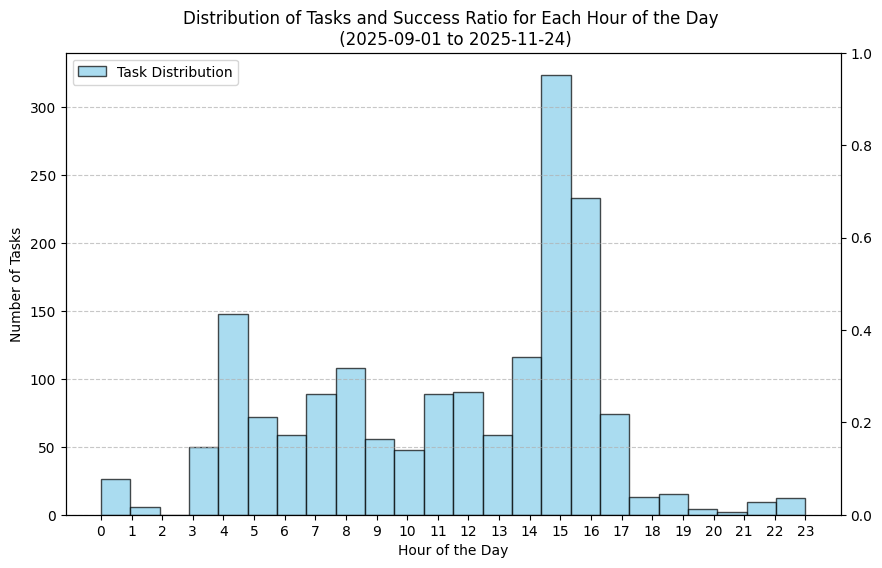

In [20]:
# @title Monthly distribution

import matplotlib.pyplot as plt

# Define the date interval
date_begin = concatenated_df['DATE'].min().strftime("%Y-%m-%d")
date_end = concatenated_df['DATE'].max().strftime("%Y-%m-%d")

# Extract the hour component from the 'DATE' column
concatenated_df['Hour'] = concatenated_df['DATE'].dt.hour

# Calculate the total number of tasks for each hour of the day
task_counts = concatenated_df.groupby('Hour').size()

# Calculate the success ratio for each hour of the day
success_counts = concatenated_df[concatenated_df['STATUS'] == 'COMPLETED'].groupby('Hour').size()
success_ratio = success_counts / task_counts

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the distribution of tasks for each hour of the day
ax1.hist(concatenated_df['Hour'], bins=24, color='skyblue', edgecolor='black', alpha=0.7, label='Task Distribution')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Number of Tasks')
ax1.set_title(f'Distribution of Tasks and Success Ratio for Each Hour of the Day \n ({date_begin} to {date_end})')
ax1.set_xticks(range(24))
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')

# Create a secondary y-axis for success ratio
ax2 = ax1.twinx()
ax2.plot(range(24), success_ratio, color='orange', marker='o', label='Success Ratio')
ax2.set_ylabel('Success Ratio')
ax2.set_ylim(0, 1)
ax2.grid(False)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# @title Distribution of Tasks and Success Ratio for Each Hour of the Day


import matplotlib.pyplot as plt

# Define the date interval
date_begin = concatenated_df['DATE'].min().strftime("%Y-%m-%d")
date_end = concatenated_df['DATE'].max().strftime("%Y-%m-%d")

# Filter the DataFrame to include only tasks associated with the specified workerpool
workerpool_df = concatenated_df[concatenated_df['WORKERPOOL ID'] == workerpool_prod]  # Replace '0X7...' with the actual workerpool ID

# Extract the hour component from the 'DATE' column
workerpool_df['Hour'] = workerpool_df['DATE'].dt.hour

# Calculate the total number of tasks for each hour of the day within the specified workerpool
task_counts = workerpool_df.groupby('Hour').size()

# Calculate the success ratio for each hour of the day within the specified workerpool
success_counts = workerpool_df[workerpool_df['STATUS'] == 'COMPLETED'].groupby('Hour').size()
success_ratio = success_counts / task_counts

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the distribution of tasks for each hour of the day within the specified workerpool
ax1.hist(workerpool_df['Hour'], bins=24, color='skyblue', edgecolor='black', alpha=0.7, label='Task Distribution')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Number of Tasks')
ax1.set_title(f'Distribution of Tasks and Success Ratio for Each Hour of the Day \n ({date_begin} to {date_end}) - Workerpool: 0X7...')
ax1.set_xticks(range(24))
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')

# Create a secondary y-axis for success ratio
ax2 = ax1.twinx()
ax2.plot(range(24), success_ratio, color='orange', marker='o', label='Success Ratio')
ax2.set_ylabel('Success Ratio')
ax2.set_ylim(0, 1)
ax2.grid(False)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# @title Distribution of Tasks and Success Ratio for Each Day of the Week

import matplotlib.pyplot as plt

# Define the date interval
date_begin = concatenated_df['DATE'].min().strftime("%Y-%m-%d")
date_end = concatenated_df['DATE'].max().strftime("%Y-%m-%d")

# Filter the DataFrame to include only tasks associated with the specified workerpool
workerpool_df = concatenated_df[concatenated_df['WORKERPOOL ID'] == workerpool_prod]  # Replace '0X7...' with the actual workerpool ID

# Extract the day of the week component from the 'DATE' column
workerpool_df['Day of Week'] = workerpool_df['DATE'].dt.dayofweek

# Calculate the total number of tasks for each day of the week within the specified workerpool
task_counts = workerpool_df.groupby('Day of Week').size()

# Calculate the success ratio for each day of the week within the specified workerpool
success_counts = workerpool_df[workerpool_df['STATUS'] == 'COMPLETED'].groupby('Day of Week').size()
success_ratio = success_counts / task_counts

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the distribution of tasks for each day of the week within the specified workerpool
ax1.bar(range(7), task_counts, color='skyblue', label='Task Distribution')
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Number of Tasks')
ax1.set_title(f'Distribution of Tasks and Success Ratio for Each Day of the Week \n ({date_begin} to {date_end}) - Workerpool: {workerpool_prod}')
ax1.set_xticks(range(7))
ax1.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')

# Create a secondary y-axis for success ratio
ax2 = ax1.twinx()
ax2.plot(range(7), success_ratio, color='orange', marker='o', label='Success Ratio')
ax2.set_ylabel('Success Ratio')
ax2.set_ylim(0, 1)
ax2.grid(False)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


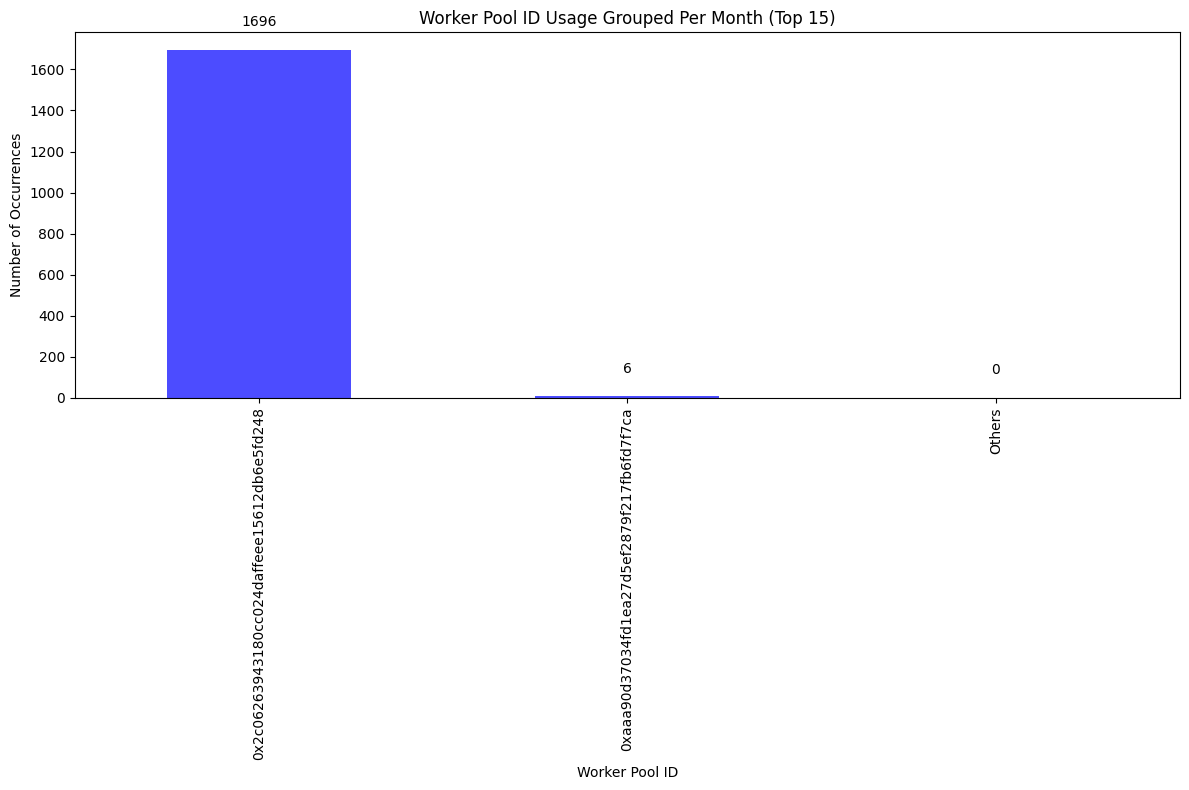

In [21]:
# @title Worker Pool ID Usage

import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'DATE' column is in datetime format
concatenated_df['DATE'] = pd.to_datetime(concatenated_df['DATE'])

# Extract month and year from the 'DATE' column
concatenated_df['MONTH'] = concatenated_df['DATE'].dt.month
concatenated_df['YEAR'] = concatenated_df['DATE'].dt.year

# Group by 'WORKERPOOL ID', 'YEAR', and 'MONTH', and count the occurrences
usage_per_month = concatenated_df.groupby(['WORKERPOOL ID', 'YEAR', 'MONTH']).size().reset_index(name='COUNT')

# Aggregate the counts of all worker pool IDs
total_counts = usage_per_month.groupby('WORKERPOOL ID')['COUNT'].sum()

# Select the top 15 worker pool IDs
top_15_workerpool = total_counts.nlargest(15)

# Group the rest into a new label "Others"
other_count = total_counts.drop(top_15_workerpool.index).sum()

# Combine the counts of the top 15 IDs and the rest
combined_counts = pd.concat([top_15_workerpool, pd.Series({'Others': other_count})])

# Plot the worker pool ID distribution usage grouped per month
plt.figure(figsize=(12, 8))
combined_counts.plot(kind='bar', color='blue', alpha=0.7)

# Add labels outside the plot
for i, (label, count) in enumerate(combined_counts.items()):
    plt.text(i, count + 100, str(count), ha='center', va='bottom')

plt.title('Worker Pool ID Usage Grouped Per Month (Top 15)')
plt.xlabel('Worker Pool ID')
plt.ylabel('Number of Occurrences')
plt.tight_layout()
plt.show()


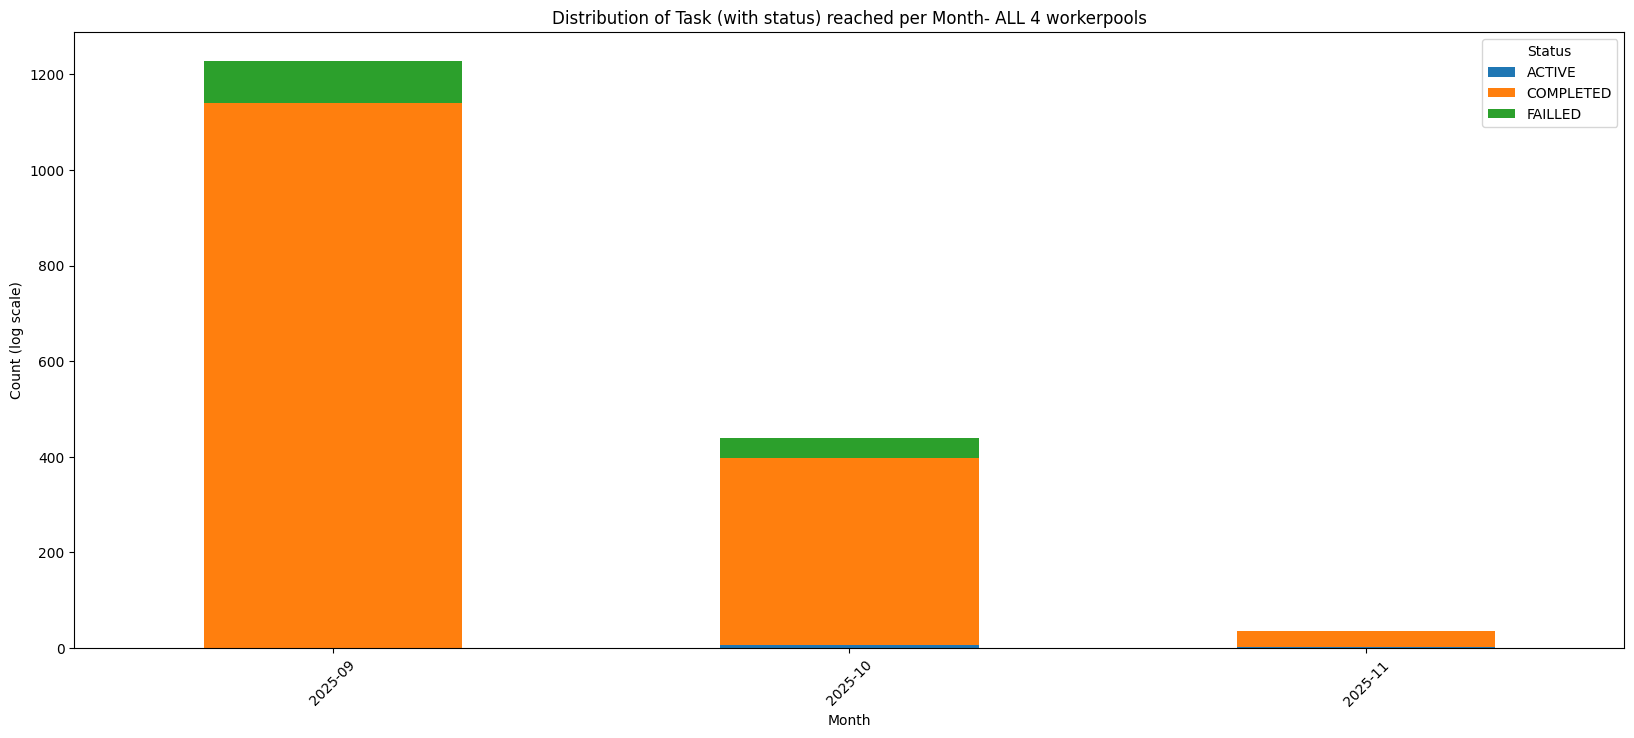

In [23]:
# @title Activity on 4 main workerpools

import pandas as pd
import matplotlib.pyplot as plt


# Assuming your DataFrame is named 'df'
# Convert DATE column to datetime if it's not already
concatenated_df['DATE'] = pd.to_datetime(concatenated_df['DATE'])
tmp_df = concatenated_df[
    (concatenated_df['WORKERPOOL ID'] == workerpool_prod_arb) |
    (concatenated_df['WORKERPOOL ID'] == workerpool_debug_arb)
]
# Extract month from the DATE column
tmp_df['Month'] = tmp_df['DATE'].dt.to_period('M')

# Group by Month and STATUS, count occurrences
status_counts = tmp_df.groupby(['Month', 'STATUS']).size().unstack(fill_value=0)

# Plot
status_counts.plot(kind='bar', stacked=True, figsize=(20, 8))
plt.title('Distribution of Task (with status) reached per Month- ALL 4 workerpools')
plt.xlabel('Month')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)
plt.legend(title='Status')

# Change y-axis to log scale
# plt.yscale('log')

plt.show()



/tmp/ipython-input-1258023778.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prodhist['Month'] = df_prodhist['DATE'].dt.to_period('M')


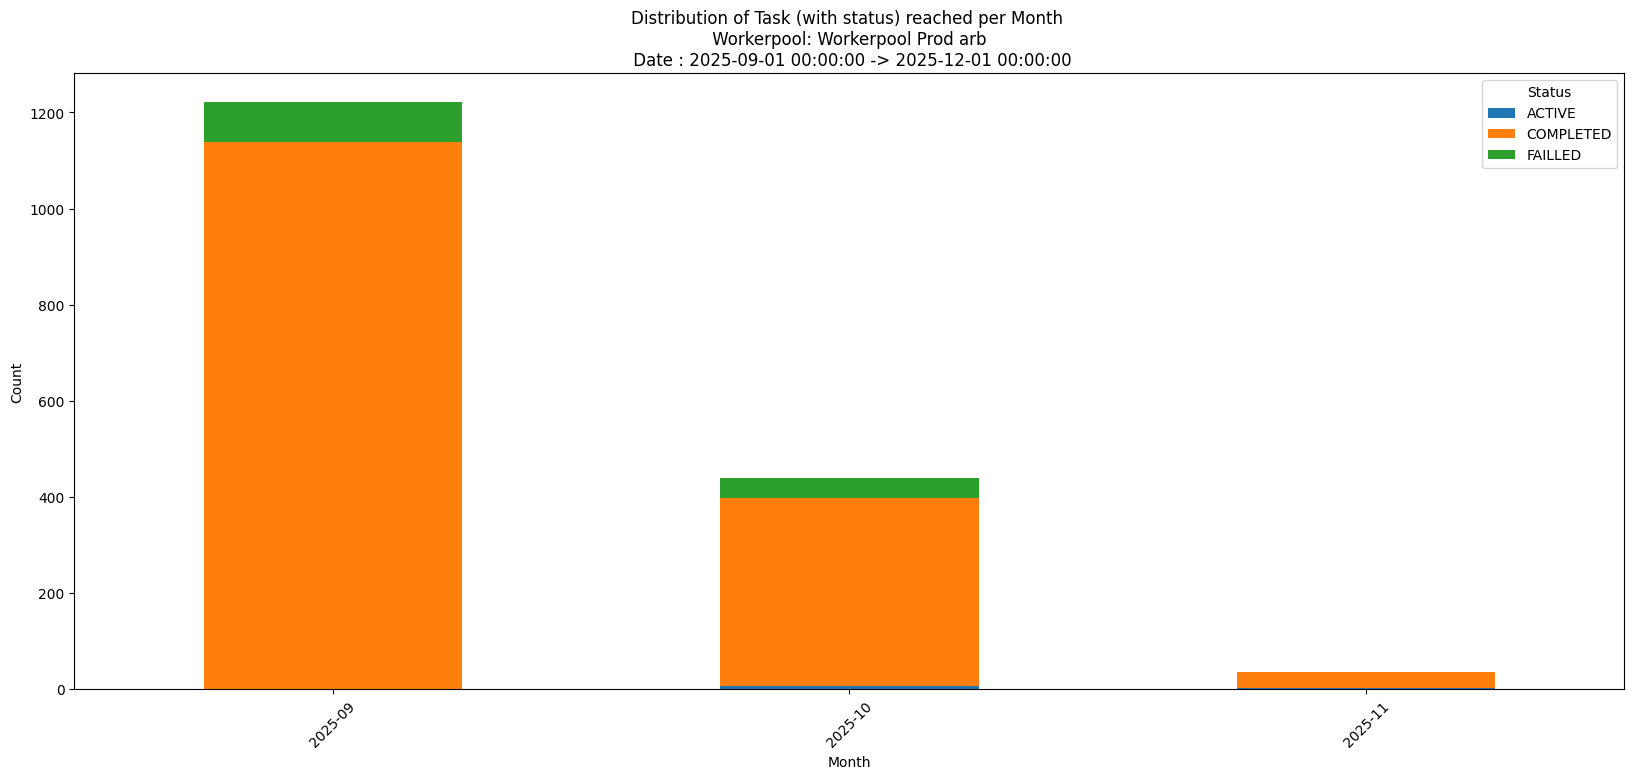

/tmp/ipython-input-1258023778.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prodhist['Month'] = df_prodhist['DATE'].dt.to_period('M')


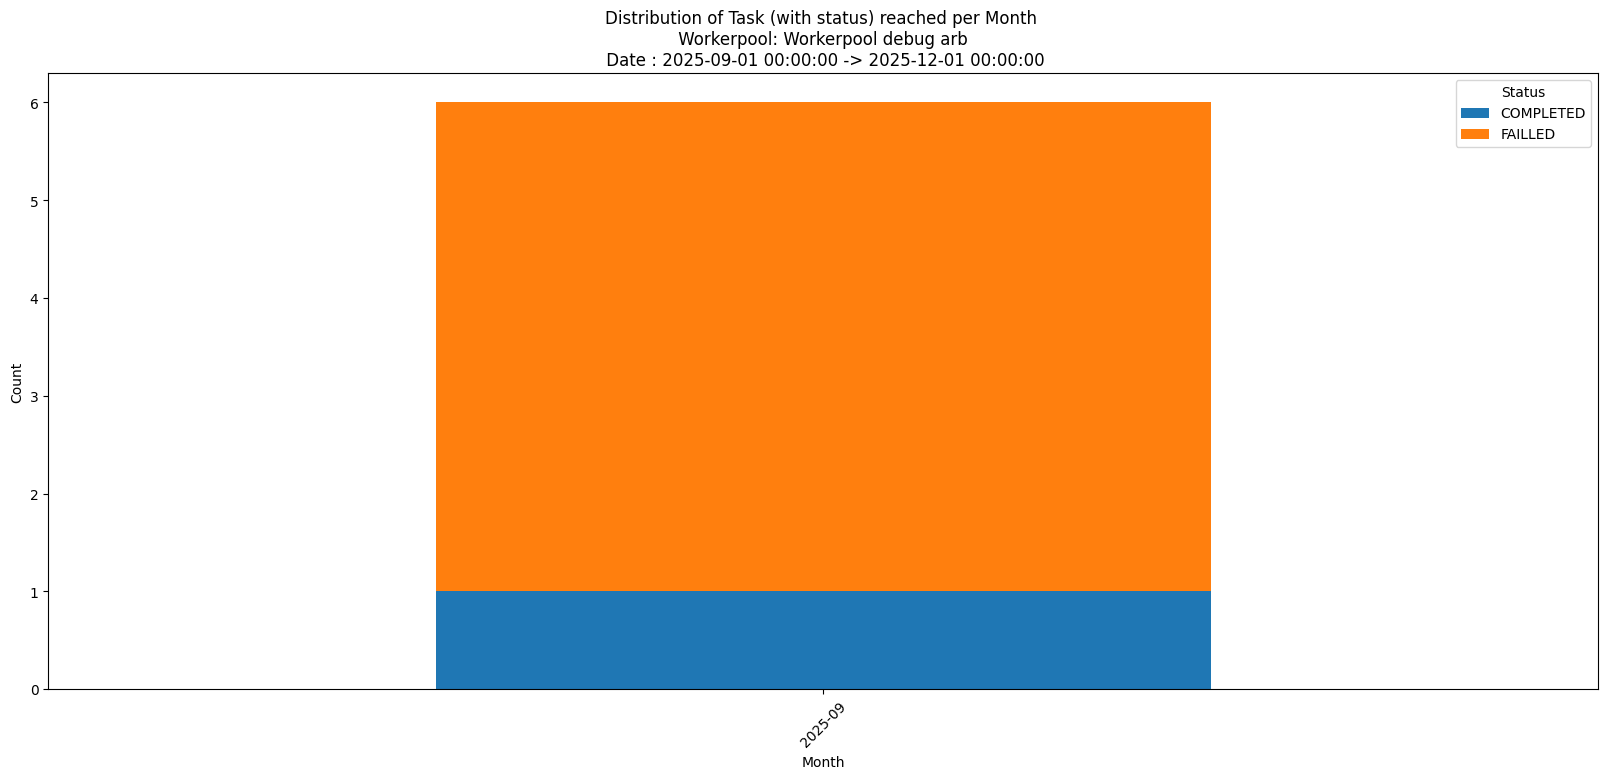

/tmp/ipython-input-1258023778.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Month'] = df_filtered['DATE'].dt.to_period('M')
/tmp/ipython-input-1258023778.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Month'] = df_filtered['DATE'].dt.to_period('M')


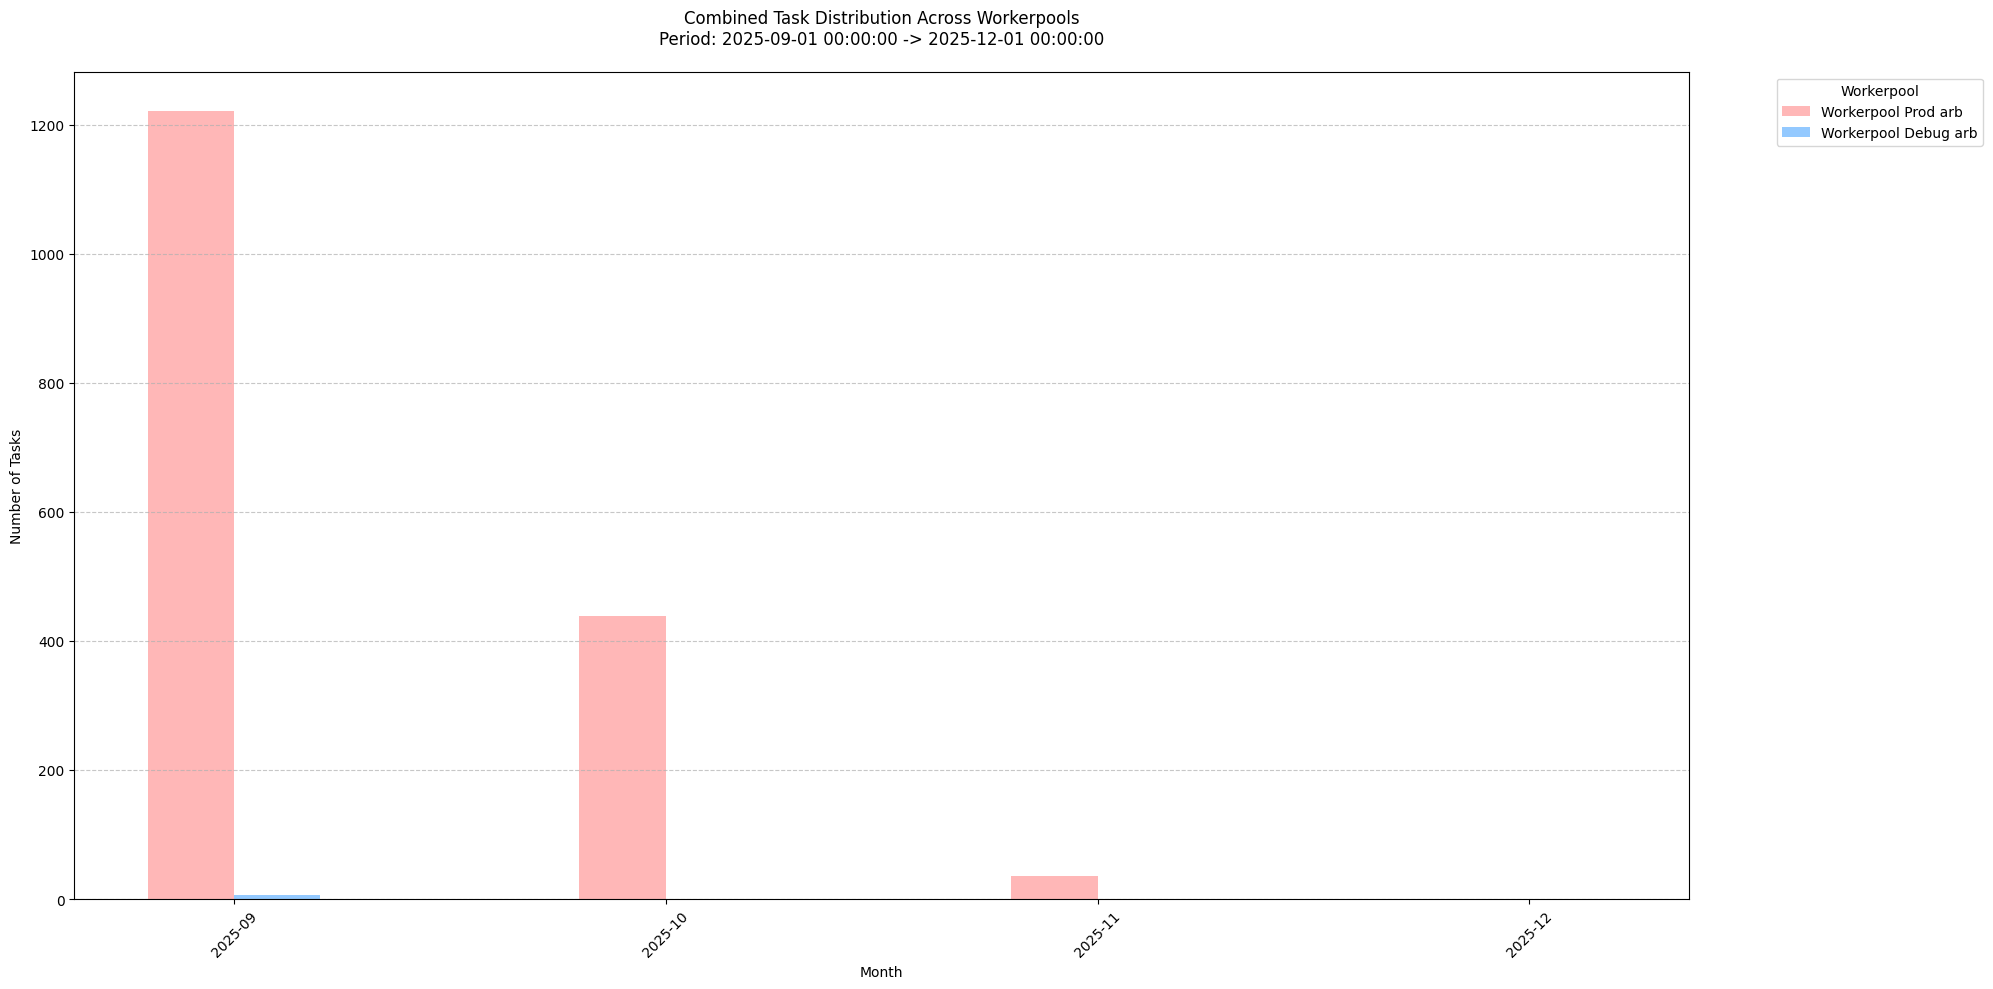

In [27]:
# @title Month activity on 4 main workerpools


def month_plot(df, workerpool_filter, start, end, wp_name):
    date_begin = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    date_end = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
    # Convert start and end dates to datetime if they are not already
    if isinstance(start, str):
        start = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    if isinstance(end, str):
        end = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')

    # Filter the DataFrame with date start, end
    df['DATE'] = pd.to_datetime(df['DATE'])
    df_filtered = df[(df['DATE'] >= start) & (df['DATE'] <= end)]

    # Filter the DataFrame further for the specific worker pool
    df_prodhist = df_filtered[df_filtered['WORKERPOOL ID'] == workerpool_filter]

    # Debug: Check workerpool filtered DataFrame
    # Extract month from the DATE column
    df_prodhist['Month'] = df_prodhist['DATE'].dt.to_period('M')

    # Group by Month and STATUS, count occurrences
    status_counts = df_prodhist.groupby(['Month', 'STATUS']).size().unstack(fill_value=0)

    # Plot
    if not status_counts.empty:
        status_counts.plot(kind='bar', stacked=True, figsize=(20, 8))
#      plt.title(f'Distribution of Task (with status) reached per Month - {wp_name}')
        plt.title('Distribution of Task (with status) reached per Month \n Workerpool: {} \n Date : {} -> {}'.format(wp_name, start, end))
        plt.xlabel('Month')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title='Status')
        plt.show()
    else:
        print("[DEBUG] No numeric data to plot.")

# Example usage

month_plot(concatenated_df, workerpool_prod_arb,'2025-09-01 00:00:00','2025-12-01 00:00:00', "Workerpool Prod arb")
month_plot(concatenated_df, workerpool_debug_arb,'2025-09-01 00:00:00','2025-12-01 00:00:00', "Workerpool debug arb")



def combined_workerpool_plot(df, workerpool_configs, start, end):
    """
    Create a combined plot for multiple workerpools showing task distribution over time.
    All workerpools will use the same date range for comparison.

    Args:
        df: DataFrame with the data
        workerpool_configs: List of tuples containing (workerpool_id, name)
        start: Global start date for all workerpools
        end: Global end date for all workerpools
    """
    # Convert dates to datetime
    date_start = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    date_end = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')

    # Convert DataFrame dates
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Create figure with subplots
    fig, ax = plt.subplots(figsize=(20, 10))

    # Color palette for different workerpools
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

    # Filter the main DataFrame for the date range
    df_date_filtered = df[(df['DATE'] >= date_start) & (df['DATE'] <= date_end)]

    # Store data for plotting
    all_monthly_counts = []

    for idx, (workerpool_id, name) in enumerate(workerpool_configs):
        # Filter for this workerpool
        df_filtered = df_date_filtered[df_date_filtered['WORKERPOOL ID'] == workerpool_id]

        # Get monthly counts
        df_filtered['Month'] = df_filtered['DATE'].dt.to_period('M')
        monthly_counts = df_filtered.groupby('Month').size()

        # Ensure all months are present (fill missing months with 0)
        date_range = pd.period_range(start=date_start, end=date_end, freq='M')
        monthly_counts = monthly_counts.reindex(date_range, fill_value=0)

        # Store data for plotting
        all_monthly_counts.append((monthly_counts, name, colors[idx]))

    # Plot all workerpools
    bar_width = 0.2
    for idx, (counts, name, color) in enumerate(all_monthly_counts):
        positions = [i + (idx * bar_width) for i in range(len(counts))]
        plt.bar(positions, counts.values, bar_width,
                label=name, color=color, alpha=0.7)

    # Customize plot
    plt.title('Combined Task Distribution Across Workerpools\n'
              f'Period: {start} -> {end}', pad=20)
    plt.xlabel('Month')
    plt.ylabel('Number of Tasks')

    # Set x-axis labels
    if all_monthly_counts:
        months = all_monthly_counts[0][0].index
        plt.xticks([i + (bar_width * (len(workerpool_configs)-1)/2) for i in range(len(months))],
                  months.astype(str),
                  rotation=45)

    plt.legend(title='Workerpool', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    return plt.gcf()

# Example usage
workerpool_configs = [
    (workerpool_prod_arb, "Workerpool Prod arb"),
    (workerpool_debug_arb, "Workerpool Debug arb"),

]

fig = combined_workerpool_plot(concatenated_df, workerpool_configs,
                             '2025-09-01 00:00:00', '2025-12-01 00:00:00')
plt.show()

In [28]:
# @title App table on 4 main workerpool

import pandas as pd

def month_table(df, workerpool_filter, start, end, wp_name, filename=None):
    # Filter the DataFrame with date start, end
    df_filtered = df[(df['DATE'] >= start) & (df['DATE'] <= end)]

    # Filter the DataFrame further for the specific worker pool
    df_filtered = df_filtered[df_filtered['WORKERPOOL ID'] == workerpool_filter]

    # Extract month from the DATE column
    df_filtered['Month'] = df_filtered['DATE'].dt.to_period('M')

    # Group by Month and APP NAME, count occurrences
    app_counts = df_filtered.groupby(['Month', 'APP NAME']).size().unstack(fill_value=0)

    # Add a "Total" column to calculate the sum of each row
    app_counts['Total'] = app_counts.sum(axis=1)

    # Transpose the DataFrame to reverse lines and columns
    app_counts_sorted_transposed = app_counts.T

    # Add a column for the total for each line
    app_counts_sorted_transposed['Total'] = app_counts_sorted_transposed.sum(axis=1)

    # Sort the DataFrame by the "Total" column
    app_counts_sorted_transposed = app_counts_sorted_transposed.sort_values(by='Total', ascending=False)

    # Format the transposed DataFrame as a table
    csvtable = app_counts_sorted_transposed
    table = app_counts_sorted_transposed.to_string()

    # Display the table
    print('App usage per month on Workerpool: {} {} \nPeriod: [{} -> {}]\n'.format(wp_name, workerpool_filter, start, end))
    print(table)

    # Save the table to a CSV file if filename is provided
    if filename:
        app_counts_sorted_transposed.to_csv(filename)
        print(f'Table saved to {filename}')

    return csvtable


# Example usage
summary_prod=month_table(concatenated_df, workerpool_prod_arb, '2025-09-01 00:00:00', '2025-12-01 00:00:00', "Workerpool Prod arb")
summary_debug=month_table(concatenated_df, workerpool_debug_arb, '2025-09-01 00:00:00', '2025-12-01 00:00:00', "Workerpool Debug arb")

#month_table(concatenated_df, workerpool_prod, '2023-01-01 00:00:00', '2024-11-01 00:00:00', "V8 prod", filename="/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/V8-prod_Jan23-may24.csv")
#month_table(concatenated_df, workerpool_debug, '2023-01-01 00:00:00', '2024-11-01 00:00:00', "V8 debug",filename="/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/V8-debug_Jan23-may24.csv")

#summary_prod.to_csv("/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/summary-wp-prod.csv")
#summary_debug.to_csv("/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/summary-wp-debug.csv")
#summary_learn_prod.to_csv("/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/summary-wp-learn-prod.csv")
#summary_learn_debug.to_csv("/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/summary-wp-learn-debug.csv")

App usage per month on Workerpool: Workerpool Prod arb 0x2c06263943180cc024daffeee15612db6e5fd248 
Period: [2025-09-01 00:00:00 -> 2025-12-01 00:00:00]

Month            2025-09  2025-10  2025-11  Total
APP NAME                                         
Total               1221      439       36   1696
web3mail             785      216       14   1015
web3telegram         426      223       14    663
hello-arb-0.0.1        5        0        3      8
hw3-0.0.1              0        0        5      5
iexec-0.0.1            4        0        0      4
hello-world            1        0        0      1
App usage per month on Workerpool: Workerpool Debug arb 0xaaa90d37034fd1ea27d5ef2879f217fb6fd7f7ca 
Period: [2025-09-01 00:00:00 -> 2025-12-01 00:00:00]

Month                  2025-09  Total
APP NAME                             
Total                        6      6
hello-world                  5      5
protecteddatadelivery        1      1


In [ ]:
# @title table saving

def save_period(df, start, end, filename):
    date_begin = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    date_end = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')
    # Convert start and end dates to datetime if they are not already
    if isinstance(start, str):
        start = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    if isinstance(end, str):
        end = datetime.strptime(end, '%Y-%m-%d %H:%M:%S')

    # Filter the DataFrame with date start, end
    df['DATE'] = pd.to_datetime(df['DATE'])
    df_filtered = df[(df['DATE'] >= start) & (df['DATE'] <= end)]


    print("Period observed", df_filtered["DATE"].min(), df_filtered["DATE"].max())
    print("dataset length: " + str(df_filtered.shape[0]))


    # Save the DataFrame to CSV with the new filename !!! uncomment
    #df_filtered.to_csv(filename, index=False)


#filename='/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/data/tasks_2023.csv'
#save_period(concatenated_df,'2023-01-01 00:00:00','2024-01-01 00:00:00',filename)

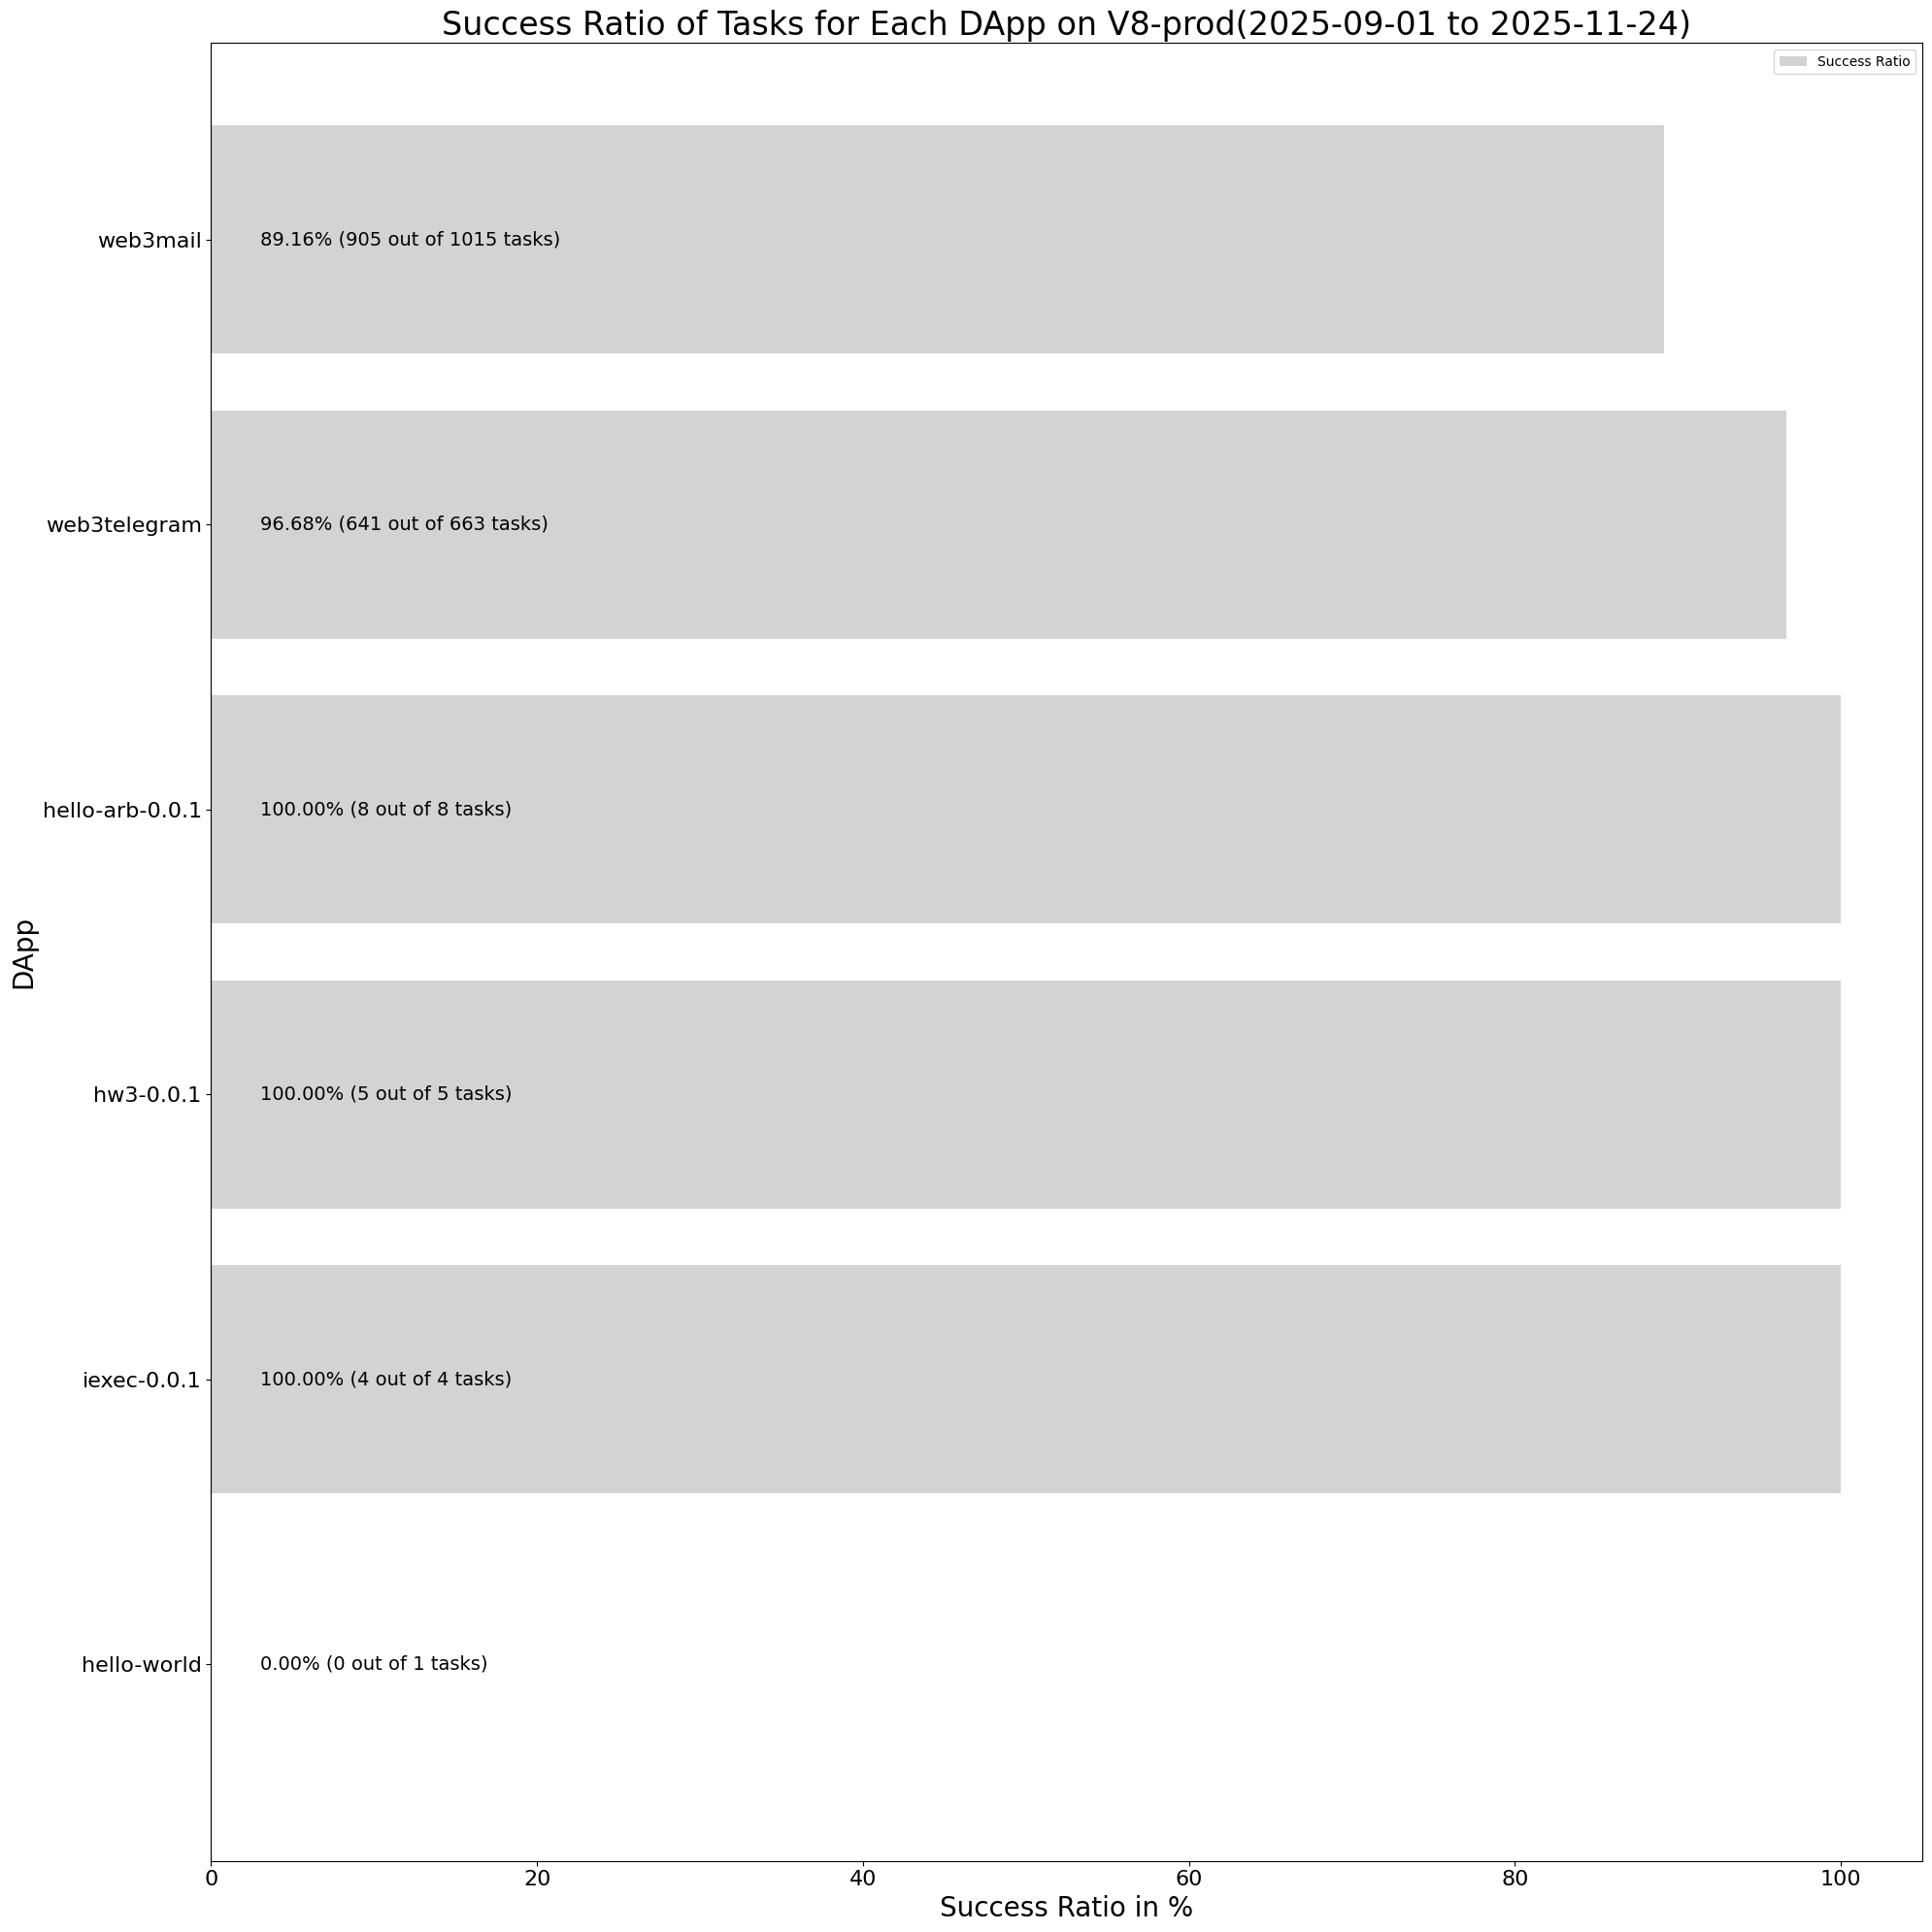

In [29]:
# @title Apps success ratio [only v8-prod]

import matplotlib.pyplot as plt

# Filter the DataFrame further for the specific worker pool
df_prodhist = concatenated_df[concatenated_df['WORKERPOOL ID'] == workerpool_prod_arb]
# Calculate the success ratio for each DApp
dapp_data = {}
for dapp, group in df_prodhist.groupby('APP NAME'):
    total_count = group.shape[0]
    success_count = group[group['STATUS'] == 'COMPLETED'].shape[0]
    ratio = success_count / total_count * 100 if total_count != 0 else 0
    dapp_data[dapp] = {'ratio': ratio, 'success_count': success_count, 'total_count': total_count}

# Sort dapp_data by total_count
sorted_dapp_data = sorted(dapp_data.items(), key=lambda x: x[1]['total_count'], reverse=False)

# Create a bar plot
plt.figure(figsize=(20, 20))
plt.barh([dapp[0] for dapp in sorted_dapp_data], [d[1]['ratio'] for d in sorted_dapp_data], color='lightgrey', label='Success Ratio')
plt.xlabel('Success Ratio in %', fontsize=20)  # Set larger fontsize for xlabel
plt.ylabel('DApp', fontsize=20)  # Set larger fontsize for ylabel
plt.title(f'Success Ratio of Tasks for Each DApp on V8-prod({date_begin} to {date_end})', fontsize=24)  # Set larger fontsize for title
plt.legend()

# Set larger fontsize for tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add annotations for success ratio and total task count
for i, (dapp, data) in enumerate(sorted_dapp_data):
    plt.text(3 , i, f'{data["ratio"]:.2f}% ({data["success_count"]} out of {data["total_count"]} tasks)', verticalalignment='center', fontsize=14)  # Set larger fontsize for annotations

plt.tight_layout()

# Save the plot before displaying it
output_path = "/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/Dashboard_from_collab"
#filename = output_path + "/Dapp_Success_rate_on_V8-prod-alltime.jpg"
#plt.savefig(filename)

# Display the plot
plt.show()


In [ ]:
# @title Availibility history


# Assuming df_alltime_specific contains your DataFrame with the provided structure

def availability(df, workerpool_filter, start, end):
    # Filter the DataFrame further for the specific worker pool
    df_filtered = df[df['WORKERPOOL ID'] == workerpool_filter]
    df_filtered = df_filtered.sort_values(by='DATE')
    specific_app1 = 'docker.io/iexechub/python-hello-world:8.0.0-sconify-5.7.5-v14-production'
    specific_app2 = 'docker.io/iexechub/python-hello-world:8.0.0-sconify-5.7.6-v15-production'
    specific_app3 = 'docker.io/iexechub/python-hello-world:8.0.0-sconify-5.9.1-v15-production'

    # Filter for specific applications
    df_filtered = df_filtered[(df_filtered['APP MULTIADDR'] == specific_app1) | (df_filtered['APP MULTIADDR'] == specific_app2) | (df_filtered['APP MULTIADDR'] == specific_app3)].copy()

    # Filter the DataFrame with date start, end
    df_filtered = df_filtered[(df_filtered['DATE'] >= start) & (df_filtered['DATE'] <= end)]

    test = df_filtered
    # Initialize variables to track "up" time intervals and downtime intervals
    up_intervals = []
    down_intervals = []

    # Initialize variables to track the start time and count of successful tasks within the interval
    start_time = None
    success_count = 0
    test.index = pd.RangeIndex(1, len(test.index) + 1)
    up = pd.Timedelta(0)
    down = pd.Timedelta(0)
    down_intervals = []

    # Iterate over the sorted DataFrame
    for index, row in test.iterrows():
        if index < len(test) - 1:
            next_row = test.loc[index + 1]

            # Check if both the current and next observations are COMPLETED
            if (row["STATUS"] == "COMPLETED") and (next_row["STATUS"] == "COMPLETED"):
                # Check if the time between the current and next observations is less than or equal to 22 minutes
                if (next_row['DATE'] - row["DATE"]) <= pd.Timedelta(minutes=22):
                    up += next_row['DATE'] - row["DATE"]
                else:
                    # If the time between observations is more than 22 minutes, it's considered as down
                    down += next_row['DATE'] - row["DATE"]
                    down_intervals.append((row['DATE'], next_row["DATE"]))
            else:
                # If either the current or next observation is not COMPLETED, it's considered as down
                down += next_row['DATE'] - row["DATE"]
                down_intervals.append((row['DATE'], next_row["DATE"]))

    # Print down intervals
    print("Down Intervals:")
    for start, end in down_intervals:
        start_time = start.strftime('%Y-%m-%d %H:%M:%S')
        end_time = end.strftime('%Y-%m-%d %H:%M:%S')
        print(f" [ {start_time}  -> {end_time} ] Duration: {end - start} ")

    # Merge consecutive intervals
    compressed_intervals = []

    # Check if down_intervals is not empty before processing
    if down_intervals:
        start, end = down_intervals[0]
        for interval in down_intervals[1:]:
            if interval[0] - end <= pd.Timedelta(minutes=1):
                end = interval[1]
            else:
                compressed_intervals.append((start, end))
                start, end = interval
        compressed_intervals.append((start, end))

        print("Down compressed:")

        # Print compressed intervals
        print("\nDown compressed Intervals:")
        for start, end in compressed_intervals:
            start_time = start.strftime('%Y-%m-%d %H:%M:%S')
            end_time = end.strftime('%Y-%m-%d %H:%M:%S')
            print(f" [ {start_time}  -> {end_time} ] Duration: {end - start} ")
    else:
        print("No down intervals to compress")

    # Calculate total time, availability percentage
    total_time = df_filtered["DATE"].max() - df_filtered["DATE"].min()

    # Add a check to prevent division by zero
    if up + down > pd.Timedelta(0):
        up_percentage = (up / (up + down)) * 100
    else:
        up_percentage = 0

    # Print summary
    print("\nSummary:")
    print(f"Total Time: {total_time}")
    print(f"Up period: {up}")
    print(f"Down period: {down}")
    print(f"Availability Percentage: {up_percentage}%")
    return up_percentage, len(compressed_intervals)

# Define the worker pool

# Define the date range
start_date = datetime.strptime('2025-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime('2025-08-31 23:59:59', '%Y-%m-%d %H:%M:%S')

# Calculate availability every 15 days
current_date = start_date
result = []
while current_date < end_date - timedelta(days=30):
    next_date = current_date + timedelta(days=30)
    avail,down_intervals_nb = availability(concatenated_df, workerpool_prod, current_date, next_date)
    current_date = current_date + timedelta(days=15)
    result.append((next_date.strftime('%Y-%m-%d'), avail,down_intervals_nb))

print(result)

# Plotting
x_val = [res[0] for res in result]   # date
y_val = [res[1] for res in result]   # availibiity ratio
y2_val = [res[2] for res in result]  # Number of incidents

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot availability percentage on primary y-axis
color1 = '#1E90FF'  # Dodger blue for availability
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Availability Percentage', color=color1, fontsize=12)
line1 = ax1.plot(x_val, y_val,
                 color=color1,
                 linewidth=3,
                 linestyle='-',
                 marker='o',
                 markersize=10,
                 markerfacecolor='red',
                 markeredgecolor='darkred',
                 markeredgewidth=2,
                 label='Availability %')

# Add value labels for availability
for i, txt in enumerate(y_val):
    ax1.annotate(f'{txt:.2f}%',
                 (x_val[i], y_val[i]),
                 xytext=(10, 10),
                 textcoords='offset points',
                 fontweight='bold',
                 color='darkred')

# Customize primary axis
ax1.tick_params(axis='y', labelcolor=color1)
ax1.axhline(y=90, color='green', linestyle='--', alpha=0.7)
ax1.axhline(y=50, color='orange', linestyle='--', alpha=0.7)

# Create secondary y-axis for incidents
ax2 = ax1.twinx()
color2 = '#FF6347'  # Tomato red for incidents
ax2.set_ylabel('Number of Incidents', color=color2, fontsize=12)
line2 = ax2.plot(x_val, y2_val,
                 color=color2,
                 linewidth=3,
                 linestyle='-',
                 marker='s',
                 markersize=10,
                 markerfacecolor='orange',
                 markeredgecolor='darkorange',
                 label='Incidents')

# Add value labels for incidents
for i, txt in enumerate(y2_val):
    ax2.annotate(str(txt),
                 (x_val[i], y2_val[i]),
                 xytext=(10, -10),
                 textcoords='offset points',
                 fontweight='bold',
                 color='darkorange')

# Customize secondary axis
ax2.tick_params(axis='y', labelcolor=color2)

# Title and overall formatting
plt.title('IExec Worker Pool Availability and Incidents', fontsize=16, fontweight='bold')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

# Improve layout
plt.gcf().autofmt_xdate()
plt.grid(True, linestyle=':', color='gray', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()